### Filtrando casos em que o stacking tem até 15% de nrmse

### Usando apenas os links que a janaina enviou que sao bons

🔍 Filtro aplicado: 62 de 597 datasets mantidos com base em melhores_62_links.csv
ANÁLISE DE VARIABILIDADE - RMSE
                            Média  Desvio Padrão  Mínimo  Máximo  \
technique                                                          
LinearInterpolation       10.1026        12.4802    0.07   70.63   
BackwardFill              11.5362        14.3430    0.26   70.34   
RollingMean               10.6871        13.5848    0.20   64.52   
ForwardFill               11.0770        14.1696    0.18   72.59   
KNNImputer                 7.9224        10.2187    0.20   51.86   
Mean                       7.9224        10.2187    0.20   51.86   
Median                     7.8146        10.9352    0.18   53.08   
StackingRegressor (mean)   0.4251         0.8196    0.00    6.00   

                          Coef. Variação (%)  Coef. Variação Ajustado (%)  \
technique                                                                   
LinearInterpolation                 123.5345        

C:\Users\LARCES_MALU\AppData\Local\Temp\ipykernel_35276\1639815992.py:306: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df_plot, y='technique', x='value', ax=ax3, palette='Set2')


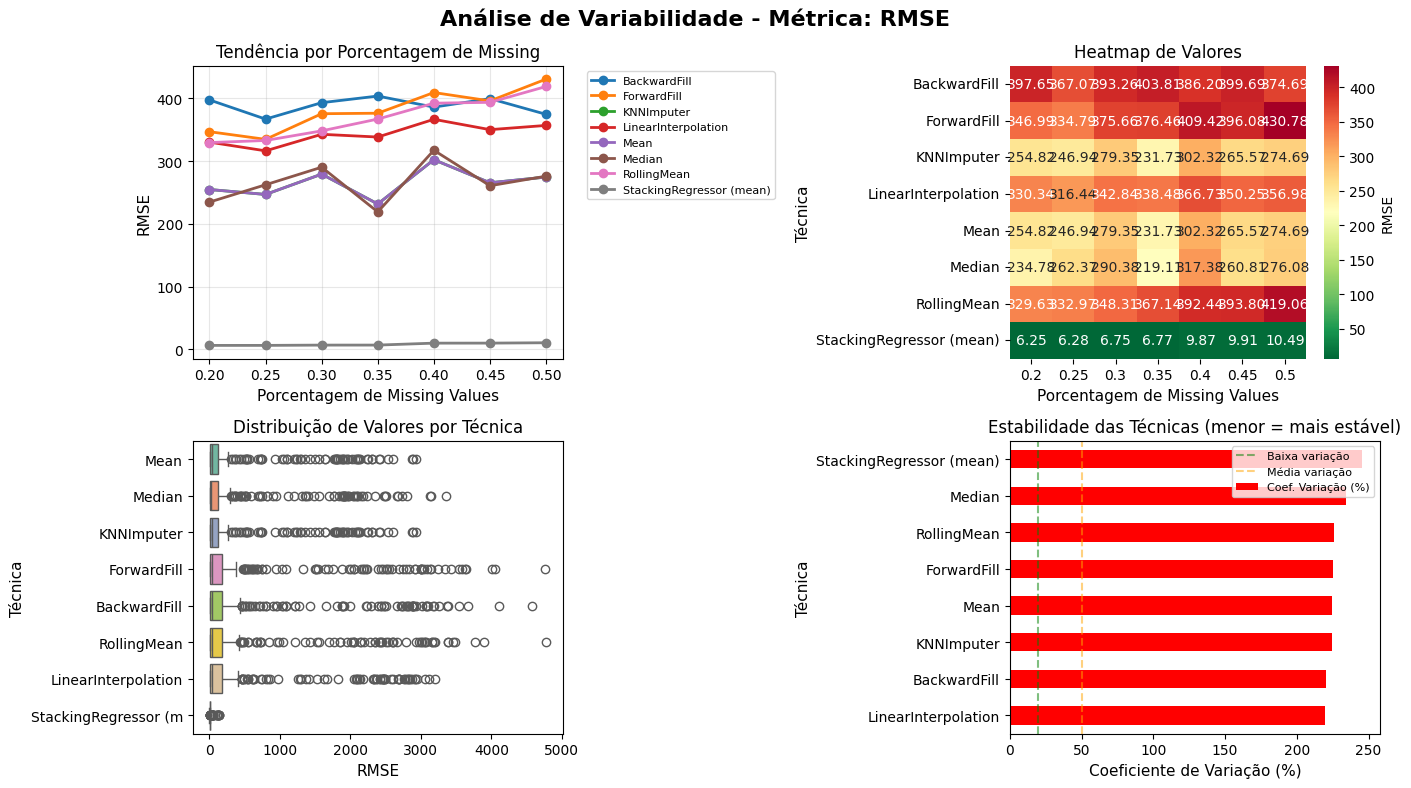


TOP 5 TÉCNICAS MAIS ESTÁVEIS E PRECISAS
                             Média  Desvio Padrão  Mínimo   Máximo  \
technique                                                            
LinearInterpolation       343.1517       753.3974    0.63  3200.81   
KNNImputer                265.0605       595.5219    1.86  2934.97   
Mean                      265.0605       595.5219    1.86  2934.97   
StackingRegressor (mean)    8.0469        19.7683    0.04   139.01   
BackwardFill              388.9094       856.3380    2.38  4580.56   
Median                    265.8437       622.3057    1.70  3349.99   
RollingMean               369.0507       834.0757    1.84  4775.42   
ForwardFill               381.4506       859.9704    1.69  4761.20   

                          Coef. Variação (%)  Coef. Variação Ajustado (%)  \
technique                                                                   
LinearInterpolation                 219.5523                     219.5523   
KNNImputer                 

In [47]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, List, Optional

class ImputationAnalyzer:
    """
    Classe para análise de variabilidade de técnicas de imputação
    em diferentes porcentagens de missing values.
    """
    
    def __init__(self, json_path: str, csv_links_path: Optional[str] = None):
        """
        Inicializa o analisador com o arquivo JSON e filtra os datasets pelos links do CSV.
        
        Args:
            json_path: Caminho para o arquivo JSON com os resultados
            csv_links_path: Caminho opcional para o CSV contendo a coluna 'link'
        """
        with open(json_path, 'r') as f:
            self.data = json.load(f)
        
        # Se foi fornecido um CSV de links, aplica o filtro
        if csv_links_path is not None:
            try:
                links_df = pd.read_csv(csv_links_path)
                if 'link' not in links_df.columns:
                    raise ValueError("O CSV deve conter uma coluna chamada 'link'.")
                
                links_validos = set(links_df['link'].astype(str).tolist())
                original_datasets = set(self.data.keys())
                # Filtra apenas os datasets (chaves do JSON) que estão no CSV
                self.data = {k: v for k, v in self.data.items() if k in links_validos}
                
                print(f"🔍 Filtro aplicado: {len(self.data)} de {len(original_datasets)} datasets mantidos com base em {csv_links_path}")
            except Exception as e:
                print(f"⚠️ Erro ao ler ou filtrar pelo CSV: {e}")
        
    def extract_metric_data(self, 
                           metric: str = 'nrmse',
                           dataset: Optional[str] = None,
                           techniques: Optional[List[str]] = None,
                           filter_by_stacking_nrmse: bool = False,
                           max_stacking_nrmse: float = 1000.0) -> pd.DataFrame:
        """
        Extrai dados de uma métrica específica para análise.
        
        Args:
            metric: Nome da métrica (rmse, nrmse, r2, mape)
            dataset: Dataset específico (None para todos)
            techniques: Lista de técnicas específicas (None para todas)
            filter_by_stacking_nrmse: Se True, filtra apenas casos onde StackingRegressor NRMSE <= max_stacking_nrmse
            max_stacking_nrmse: Threshold máximo de NRMSE do StackingRegressor (padrão: 15.0)
            
        Returns:
            DataFrame com técnicas nas linhas e porcentagens nas colunas
        """
        results = []
        valid_combinations = set()  # Para armazenar (dataset, missing_pct) válidos
        
        # Se filtro ativado, primeiro identifica combinações válidas
        if filter_by_stacking_nrmse:
            datasets = [dataset] if dataset else self.data.keys()
            
            for ds in datasets:
                if ds not in self.data:
                    continue
                    
                for missing_pct, methods in self.data[ds].items():
                    try:
                        float(missing_pct)
                    except ValueError:
                        continue
                    
                    # Verifica se StackingRegressor NRMSE <= threshold
                    if 'stacking' in methods:
                        for stack_type, models in methods['stacking'].items():
                            for model, metrics in models.items():
                                if 'StackingRegressor' in model and 'nrmse' in metrics:
                                    if metrics['nrmse'] <= max_stacking_nrmse:
                                        valid_combinations.add((ds, float(missing_pct)))
        
        # Agora extrai os dados
        datasets = [dataset] if dataset else self.data.keys()
        
        for ds in datasets:
            if ds not in self.data:
                continue
                
            for missing_pct, methods in self.data[ds].items():
                # Ignora chaves que não são porcentagens
                try:
                    missing_pct_float = float(missing_pct)
                except ValueError:
                    continue
                
                # Se filtro ativado, verifica se esta combinação é válida
                if filter_by_stacking_nrmse:
                    if (ds, missing_pct_float) not in valid_combinations:
                        continue
                
                # Processa baseline
                if 'baseline' in methods:
                    for technique, metrics in methods['baseline'].items():
                        if techniques and technique not in techniques:
                            continue
                        if metric in metrics:
                            results.append({
                                'dataset': ds,
                                'missing_pct': missing_pct_float,
                                'technique': technique,
                                'value': metrics[metric],
                                'type': 'baseline'
                            })
                
                # Processa stacking
                if 'stacking' in methods:
                    for stack_type, models in methods['stacking'].items():
                        for model, metrics in models.items():
                            technique_name = f"{model} ({stack_type})"
                            if techniques and technique_name not in techniques:
                                continue
                            if metric in metrics:
                                results.append({
                                    'dataset': ds,
                                    'missing_pct': missing_pct_float,
                                    'technique': technique_name,
                                    'value': metrics[metric],
                                    'type': 'stacking'
                                })
        
        df = pd.DataFrame(results)
        
        if filter_by_stacking_nrmse and len(df) > 0:
            n_combinations = len(valid_combinations)
            datasets_used = len(set([x[0] for x in valid_combinations]))
            print(f"🔍 Filtro aplicado: NRMSE(StackingRegressor) ≤ {max_stacking_nrmse}%")
            print(f"✓ {n_combinations} combinações válidas encontradas em {datasets_used} datasets")
        
        return df
    
    def detect_outliers(self, 
                       metric: str = 'rmse',
                       dataset: Optional[str] = None,
                       method: str = 'iqr',
                       threshold: float = 3.0,
                       filter_by_stacking_nrmse: bool = False,
                       max_stacking_nrmse: float = 1000.0) -> pd.DataFrame:
        """
        Detecta outliers nos dados.
        
        Args:
            metric: Nome da métrica
            dataset: Dataset específico
            method: Método de detecção ('iqr', 'zscore', 'percentile')
            threshold: Threshold para detecção (IQR multiplier, Z-score, ou percentil)
            filter_by_stacking_nrmse: Se True, filtra por NRMSE do Stacking
            max_stacking_nrmse: Threshold máximo de NRMSE
            
        Returns:
            DataFrame com outliers identificados
        """
        df = self.extract_metric_data(metric, dataset, None, 
                                     filter_by_stacking_nrmse, max_stacking_nrmse)
        
        if method == 'iqr':
            Q1 = df['value'].quantile(0.25)
            Q3 = df['value'].quantile(0.75)
            IQR = Q3 - Q1
            lower_bound = Q1 - threshold * IQR
            upper_bound = Q3 + threshold * IQR
            outliers = df[(df['value'] < lower_bound) | (df['value'] > upper_bound)]
        
        elif method == 'zscore':
            z_scores = np.abs((df['value'] - df['value'].mean()) / df['value'].std())
            outliers = df[z_scores > threshold]
        
        elif method == 'percentile':
            lower_bound = df['value'].quantile(threshold / 100)
            upper_bound = df['value'].quantile(1 - threshold / 100)
            outliers = df[(df['value'] < lower_bound) | (df['value'] > upper_bound)]
        
        return outliers.sort_values('value', ascending=False)
    
    def calculate_variability(self, 
                            metric: str = 'rmse',
                            dataset: Optional[str] = None,
                            techniques: Optional[List[str]] = None,
                            remove_outliers: bool = False,
                            outlier_method: str = 'iqr',
                            outlier_threshold: float = 3.0,
                            filter_by_stacking_nrmse: bool = False,
                            max_stacking_nrmse: float = 15.0) -> pd.DataFrame:
        """
        Calcula estatísticas de variabilidade para cada técnica.
        Inclui coeficiente de variação ajustado para médias muito pequenas.
        """
        df = self.extract_metric_data(metric, dataset, techniques, 
                                    filter_by_stacking_nrmse, max_stacking_nrmse)
        
        if remove_outliers:
            outliers = self.detect_outliers(metric, dataset, outlier_method, 
                                        outlier_threshold, filter_by_stacking_nrmse, 
                                        max_stacking_nrmse)
            outlier_indices = outliers.index
            df = df.drop(outlier_indices)
            print(f"⚠️  {len(outlier_indices)} outliers removidos")
        
        epsilon = 1e-6  # pequeno valor para evitar divisão por médias muito pequenas
        
        def adjusted_cv(x):
            mean_abs = abs(x.mean())
            return (x.std() / (mean_abs + epsilon)) * 100
        
        stats = df.groupby('technique')['value'].agg([
            ('mean', 'mean'),
            ('std', 'std'),
            ('min', 'min'),
            ('max', 'max'),
            ('cv', lambda x: x.std() / (x.mean() if x.mean() != 0 else np.nan) * 100),
            ('cv_adjusted', adjusted_cv),
            ('range', lambda x: x.max() - x.min())
        ]).round(4)
        
        stats.columns = ['Média', 'Desvio Padrão', 'Mínimo', 'Máximo', 
                        'Coef. Variação (%)', 'Coef. Variação Ajustado (%)', 'Amplitude']
        
        return stats.sort_values('Coef. Variação Ajustado (%)')

    
    def plot_variability(self,
                        metric: str = 'rmse',
                        dataset: Optional[str] = None,
                        techniques: Optional[List[str]] = None,
                        remove_outliers: bool = False,
                        outlier_method: str = 'iqr',
                        outlier_threshold: float = 3.0,
                        filter_by_stacking_nrmse: bool = False,
                        max_stacking_nrmse: float = 15.0,
                        figsize: tuple = (14, 8)):
        """
        Plota a variabilidade das técnicas através das porcentagens de missing.
        
        Args:
            metric: Nome da métrica
            dataset: Dataset específico
            techniques: Lista de técnicas específicas
            remove_outliers: Se True, remove outliers dos gráficos
            outlier_method: Método de detecção de outliers
            outlier_threshold: Threshold para detecção
            filter_by_stacking_nrmse: Se True, filtra por NRMSE do Stacking
            max_stacking_nrmse: Threshold máximo de NRMSE
            figsize: Tamanho da figura
        """
        df = self.extract_metric_data(metric, dataset, techniques,
                                     filter_by_stacking_nrmse, max_stacking_nrmse)
        
        if remove_outliers:
            outliers = self.detect_outliers(metric, dataset, outlier_method, 
                                           outlier_threshold, filter_by_stacking_nrmse,
                                           max_stacking_nrmse)
            outlier_indices = outliers.index
            df = df.drop(outlier_indices)
            print(f"⚠️  {len(outlier_indices)} outliers removidos dos gráficos")
        
        # Criar pivot table
        pivot = df.pivot_table(
            values='value',
            index='technique',
            columns='missing_pct',
            aggfunc='mean'
        )
        
        fig, axes = plt.subplots(2, 2, figsize=figsize)
        title_suffix = " (sem outliers)" if remove_outliers else ""
        if filter_by_stacking_nrmse:
            title_suffix += f" [NRMSE(Stacking) ≤ {max_stacking_nrmse}%]"
        fig.suptitle(f'Análise de Variabilidade - Métrica: {metric.upper()}{title_suffix}', 
                    fontsize=16, fontweight='bold')
        
        # 1. Linhas de tendência
        ax1 = axes[0, 0]
        for technique in pivot.index:
            ax1.plot(pivot.columns, pivot.loc[technique], 
                    marker='o', label=technique, linewidth=2)
        ax1.set_xlabel('Porcentagem de Missing Values', fontsize=11)
        ax1.set_ylabel(f'{metric.upper()}', fontsize=11)
        ax1.set_title('Tendência por Porcentagem de Missing', fontsize=12)
        ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=8)
        ax1.grid(True, alpha=0.3)
        
        # 2. Heatmap
        ax2 = axes[0, 1]
        sns.heatmap(pivot, annot=True, fmt='.2f', cmap='RdYlGn_r', 
                   ax=ax2, cbar_kws={'label': metric.upper()})
        ax2.set_title('Heatmap de Valores', fontsize=12)
        ax2.set_xlabel('Porcentagem de Missing Values', fontsize=11)
        ax2.set_ylabel('Técnica', fontsize=11)
        
        # 3. Boxplot de variabilidade
        ax3 = axes[1, 0]
        df_plot = df.copy()
        df_plot['technique'] = df_plot['technique'].str[:20]  # Truncar nomes longos
        sns.boxplot(data=df_plot, y='technique', x='value', ax=ax3, palette='Set2')
        ax3.set_xlabel(f'{metric.upper()}', fontsize=11)
        ax3.set_ylabel('Técnica', fontsize=11)
        ax3.set_title('Distribuição de Valores por Técnica', fontsize=12)
        
        # 4. Coeficiente de variação
        ax4 = axes[1, 1]
        stats = self.calculate_variability(metric, dataset, techniques, 
                                          remove_outliers, outlier_method, outlier_threshold,
                                          filter_by_stacking_nrmse, max_stacking_nrmse)
        cv_data = stats['Coef. Variação (%)'].sort_values()
        colors = ['green' if x < 20 else 'orange' if x < 50 else 'red' 
                 for x in cv_data.values]
        cv_data.plot(kind='barh', ax=ax4, color=colors)
        ax4.set_xlabel('Coeficiente de Variação (%)', fontsize=11)
        ax4.set_ylabel('Técnica', fontsize=11)
        ax4.set_title('Estabilidade das Técnicas (menor = mais estável)', fontsize=12)
        ax4.axvline(x=20, color='green', linestyle='--', alpha=0.5, label='Baixa variação')
        ax4.axvline(x=50, color='orange', linestyle='--', alpha=0.5, label='Média variação')
        ax4.legend(fontsize=8)
        
        plt.tight_layout()
        plt.show()
    
    def compare_techniques(self,
                          metric: str = 'rmse',
                          dataset: Optional[str] = None,
                          remove_outliers: bool = False,
                          outlier_method: str = 'iqr',
                          outlier_threshold: float = 3.0,
                          filter_by_stacking_nrmse: bool = False,
                          max_stacking_nrmse: float = 15.0,
                          top_n: int = 8) -> pd.DataFrame:
        """
        Compara técnicas e retorna as top N mais estáveis.
        
        Args:
            metric: Nome da métrica
            dataset: Dataset específico
            remove_outliers: Se True, remove outliers antes da comparação
            outlier_method: Método de detecção de outliers
            outlier_threshold: Threshold para detecção
            filter_by_stacking_nrmse: Se True, filtra por NRMSE do Stacking
            max_stacking_nrmse: Threshold máximo de NRMSE
            top_n: Número de técnicas a retornar
            
        Returns:
            DataFrame com ranking das técnicas
        """
        stats = self.calculate_variability(metric, dataset, None, 
                                          remove_outliers, outlier_method, outlier_threshold,
                                          filter_by_stacking_nrmse, max_stacking_nrmse)
        
        # Criar ranking
        stats['Rank_CV'] = stats['Coef. Variação (%)'].rank()
        stats['Rank_Mean'] = stats['Média'].rank()
        stats['Score'] = stats['Rank_CV'] + stats['Rank_Mean']
        
        return stats.sort_values('Score').head(top_n)
    
    def analyze_outliers_impact(self, 
                               metric: str = 'rmse',
                               dataset: Optional[str] = None,
                               filter_by_stacking_nrmse: bool = False,
                               max_stacking_nrmse: float = 15.0) -> None:
        """
        Analisa o impacto dos outliers nas estatísticas.
        
        Args:
            metric: Nome da métrica
            dataset: Dataset específico
            filter_by_stacking_nrmse: Se True, filtra por NRMSE do Stacking
            max_stacking_nrmse: Threshold máximo de NRMSE
        """
        print("=" * 70)
        print("ANÁLISE DE IMPACTO DOS OUTLIERS")
        print("=" * 70)
        
        # Detectar outliers
        outliers = self.detect_outliers(metric, dataset, method='iqr', threshold=1.5,
                                       filter_by_stacking_nrmse=filter_by_stacking_nrmse,
                                       max_stacking_nrmse=max_stacking_nrmse)
        
        total_data = self.extract_metric_data(metric, dataset, None,
                                             filter_by_stacking_nrmse, max_stacking_nrmse)
        
        print(f"\n📊 Total de outliers detectados: {len(outliers)}")
        print(f"📊 Porcentagem de outliers: {len(outliers) / len(total_data) * 100:.2f}%")
        
        print("\n🔍 Top 10 Outliers mais extremos:")
        print(outliers[['dataset', 'missing_pct', 'technique', 'value']].head(10))
        
        print("\n📈 Distribuição de outliers por técnica:")
        outlier_dist = outliers['technique'].value_counts()
        print(outlier_dist)
        
        # Comparação com e sem outliers
        print("\n" + "=" * 70)
        print("COMPARAÇÃO: COM vs SEM OUTLIERS")
        print("=" * 70)
        
        stats_with = self.calculate_variability(metric, dataset, None, False, 'iqr', 3.0,
                                               filter_by_stacking_nrmse, max_stacking_nrmse)
        stats_without = self.calculate_variability(metric, dataset, None, True, 'iqr', 3.0,
                                                   filter_by_stacking_nrmse, max_stacking_nrmse)
        
        comparison = pd.DataFrame({
            'CV_com_outliers': stats_with['Coef. Variação (%)'],
            'CV_sem_outliers': stats_without['Coef. Variação (%)'],
            'Diferença_CV': stats_with['Coef. Variação (%)'] - stats_without['Coef. Variação (%)'],
            'Melhoria_%': ((stats_with['Coef. Variação (%)'] - stats_without['Coef. Variação (%)']) / 
                          stats_with['Coef. Variação (%)'] * 100)
        }).sort_values('Melhoria_%', ascending=False)
        
        print("\n✨ Técnicas com maior melhoria ao remover outliers:")
        print(comparison.head(10))
    
    def export_results(self,
                      metric: str = 'rmse',
                      output_file: str = 'analysis_results.xlsx'):
        """
        Exporta todos os resultados para Excel.
        
        Args:
            metric: Nome da métrica
            output_file: Nome do arquivo de saída
        """
        with pd.ExcelWriter(output_file, engine='openpyxlsx') as writer:
            # Dados brutos
            df_raw = self.extract_metric_data(metric)
            df_raw.to_excel(writer, sheet_name='Dados_Brutos', index=False)
            
            # Estatísticas de variabilidade
            stats = self.calculate_variability(metric)
            stats.to_excel(writer, sheet_name='Estatisticas')
            
            # Ranking
            ranking = self.compare_techniques(metric, top_n=10)
            ranking.to_excel(writer, sheet_name='Ranking')
            
            # Pivot por dataset
            for ds in self.data.keys():
                df = self.extract_metric_data(metric, dataset=ds)
                if not df.empty:
                    pivot = df.pivot_table(
                        values='value',
                        index='technique',
                        columns='missing_pct'
                    )
                    pivot.to_excel(writer, sheet_name=f'Dataset_{ds[:20]}')
        
        print(f"✓ Resultados exportados para {output_file}")


# Exemplo de uso
if __name__ == "__main__":
    # Inicializar analisador com filtro de links
    analyzer = ImputationAnalyzer(  #datasets\multivariada-results\imputed_series_selective_unfair\metrics_summary_unfair.json
        json_path='../../datasets/multivariada-results/imputed_series_selective_unfair/metrics_summary_unfair.json',
        csv_links_path='melhores_62_links.csv'
    )
    
    # Analisar RMSE
    print("=" * 60)
    print("ANÁLISE DE VARIABILIDADE - RMSE")
    print("=" * 60)
    stats_rmse = analyzer.calculate_variability(metric='nrmse')
    print(stats_rmse)
    
    # Plotar análise
    analyzer.plot_variability(metric='rmse')
    
    # Comparar técnicas
    print("\n" + "=" * 60)
    print("TOP 5 TÉCNICAS MAIS ESTÁVEIS E PRECISAS")
    print("=" * 60)
    top_techniques = analyzer.compare_techniques(metric='rmse', top_n=8)
    print(top_techniques)
    
    # Analisar outras métricas
    for metric in ['nrmse', 'r2', 'mape']:
        print(f"\n{'=' * 60}")
        print(f"ANÁLISE - {metric.upper()}")
        print("=" * 60)
        stats = analyzer.calculate_variability(metric=metric)
        print(stats.head())


### Criando um sub-json com os links que a janaina me mandou

In [ ]:
import json
import pandas as pd

def filtrar_json_por_links(json_path: str, csv_path: str, output_path: str):
    """
    Filtra o JSON mantendo apenas as chaves (links) que estão no CSV.

    Args:
        json_path (str): Caminho do arquivo JSON original.
        csv_path (str): Caminho do CSV com a coluna 'link'.
        output_path (str): Caminho para salvar o novo JSON filtrado.
    """
    # Carrega o JSON original
    with open(json_path, 'r') as f:
        data = json.load(f)

    # Carrega o CSV e obtém a lista de links válidos
    links_df = pd.read_csv(csv_path)
    if 'link' not in links_df.columns:
        raise ValueError("O CSV deve conter uma coluna chamada 'link'.")

    links_validos = set(links_df['link'].astype(str).tolist())
    print(f"🔗 Total de links válidos no CSV: {len(links_validos)}")

    # Filtra o JSON: mantém apenas os datasets (links) que estão no CSV
    data_filtrado = {k: v for k, v in data.items() if k in links_validos}

    print(f"✅ JSON filtrado: {len(data_filtrado)} de {len(data)} links mantidos.")

    # Salva o resultado em novo arquivo JSON
    with open(output_path, 'w') as f:
        json.dump(data_filtrado, f, indent=4, ensure_ascii=False)

    print(f"💾 Novo JSON salvo em: {output_path}")


# Exemplo de uso
if __name__ == "__main__":
    filtrar_json_por_links(
        json_path='../../datasets/multivariada-results/imputed_series_selective_melhor2/metrics_summary.json',
        csv_path='melhores_62_links.csv',
        output_path='metrics_summary_filtrado_62.json'
    )


🔗 Total de links válidos no CSV: 62
✅ JSON filtrado: 62 de 384 links mantidos.
💾 Novo JSON salvo em: metrics_summary_filtrado_62.json


### Analisando apenas os links que a janaina mandou

📊 Colunas disponíveis: ['link', 'imputation_percentage', 'tipo', 'modelo', 'rmse', 'nrmse', 'r2', 'mape']
✅ JSON carregado com 3192 registros.
=== Resumo Geral ===
📊 Estatísticas descritivas por modelo e tipo:
                                  r2                             rmse  \
                                mean      std      min   max     mean   
modelo              tipo                                                
BackwardFill        baseline -56.264  504.637 -8989.18  0.21  343.530   
ForwardFill         baseline -30.796  137.836 -1910.70  0.06  354.165   
KNNImputer          baseline  -6.988   54.782 -1060.66 -0.00  252.584   
LinearInterpolation baseline -22.939  140.566 -2455.20  0.19  315.663   
Mean                baseline  -6.988   54.782 -1060.66 -0.00  252.584   
Median              baseline  -1.248    9.330  -183.77 -0.01  256.871   
RollingMean         baseline -24.578  110.190 -1496.20  0.21  336.448   
StackingRegressor   stacking  -1.834   12.008  -175.99  0.57

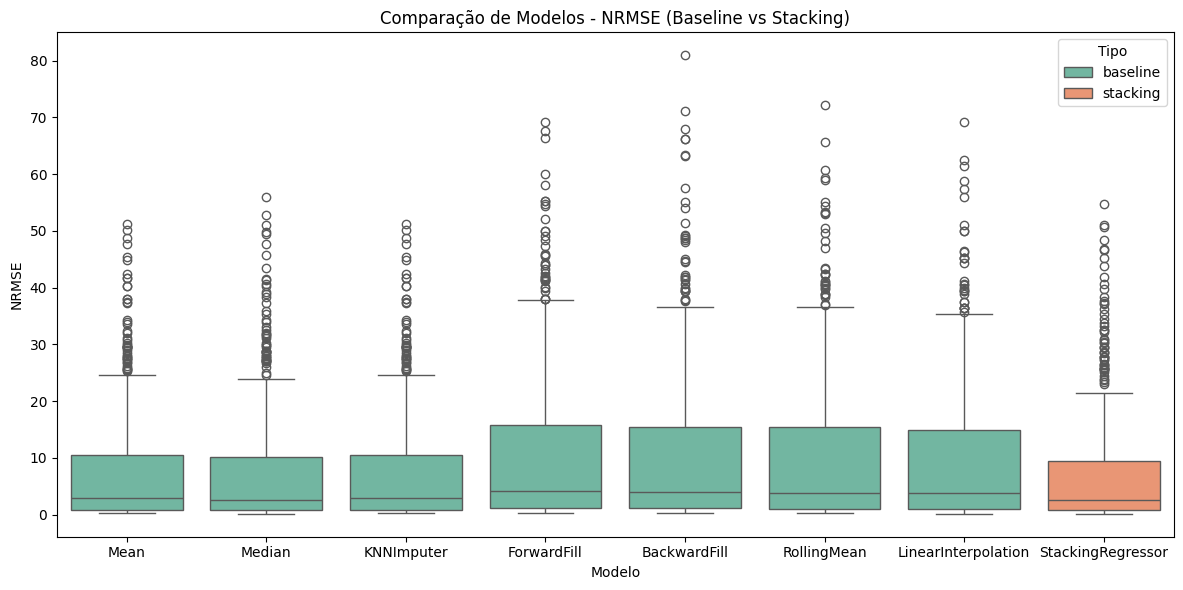

=== Variabilidade por Percentual de Imputação ===
📊 Análise por % de imputação concluída (4 métricas detectadas).


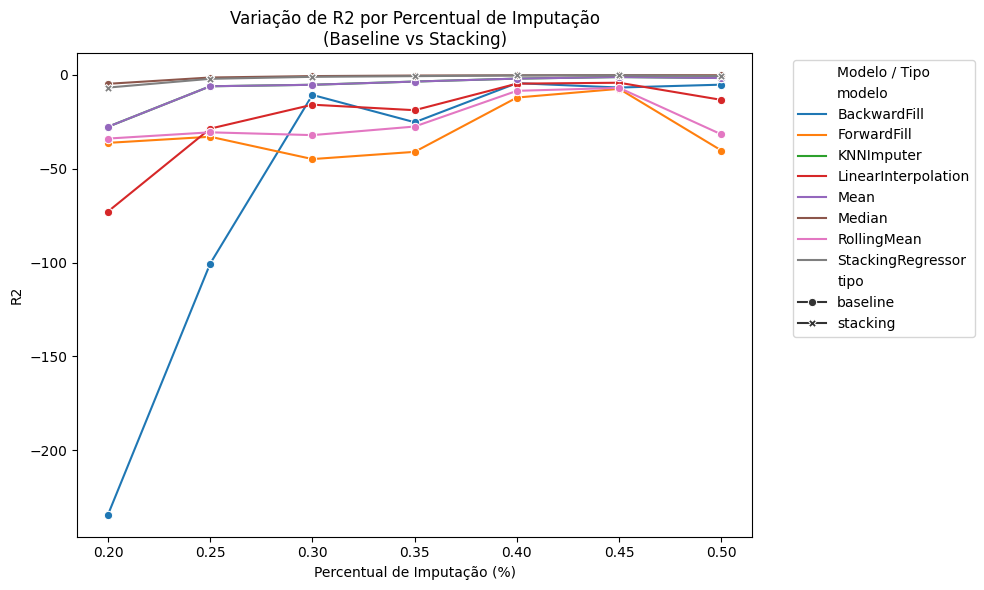

📊 Análise por % de imputação concluída (4 métricas detectadas).


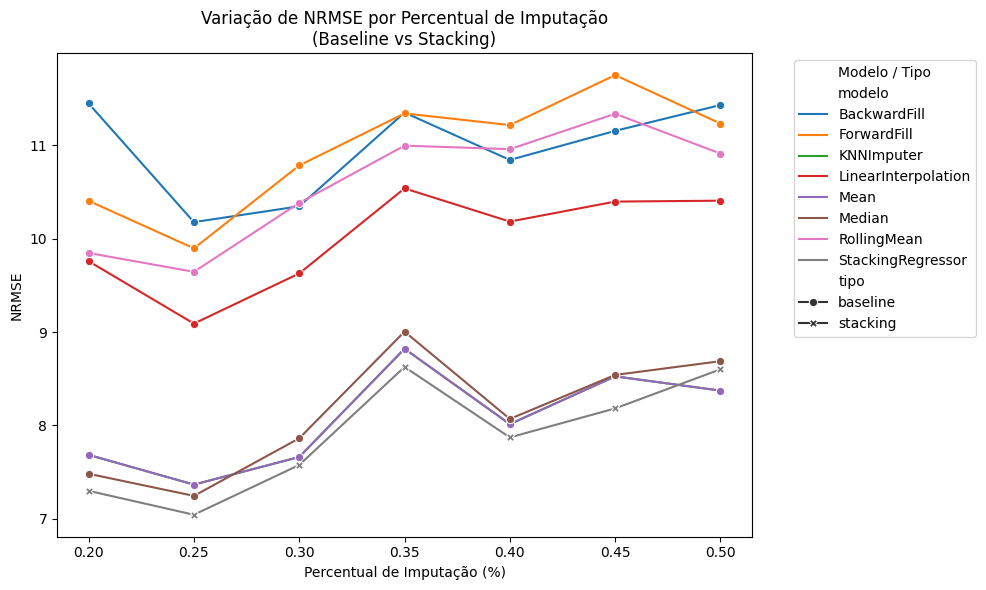

=== Correlação Métricas x Métodos ===


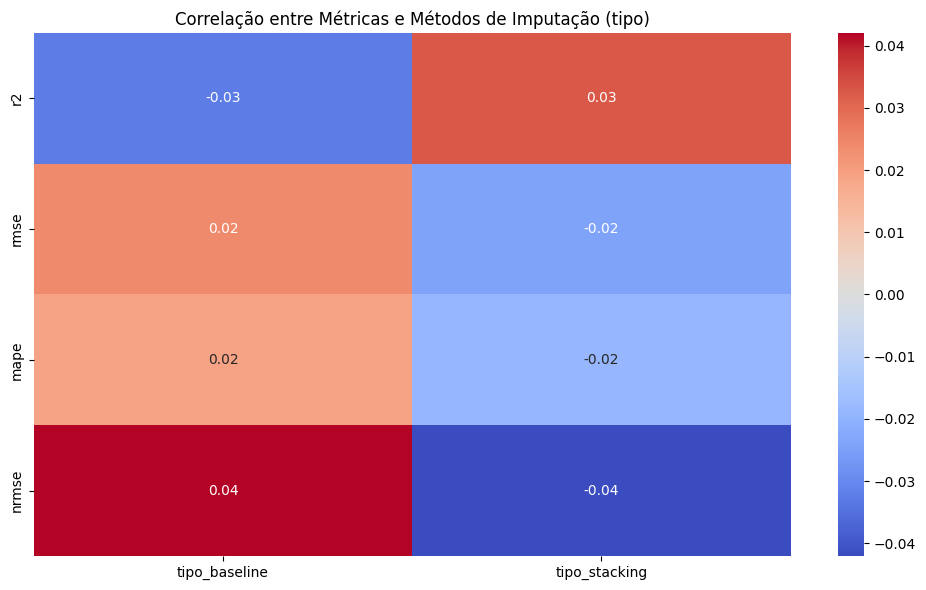

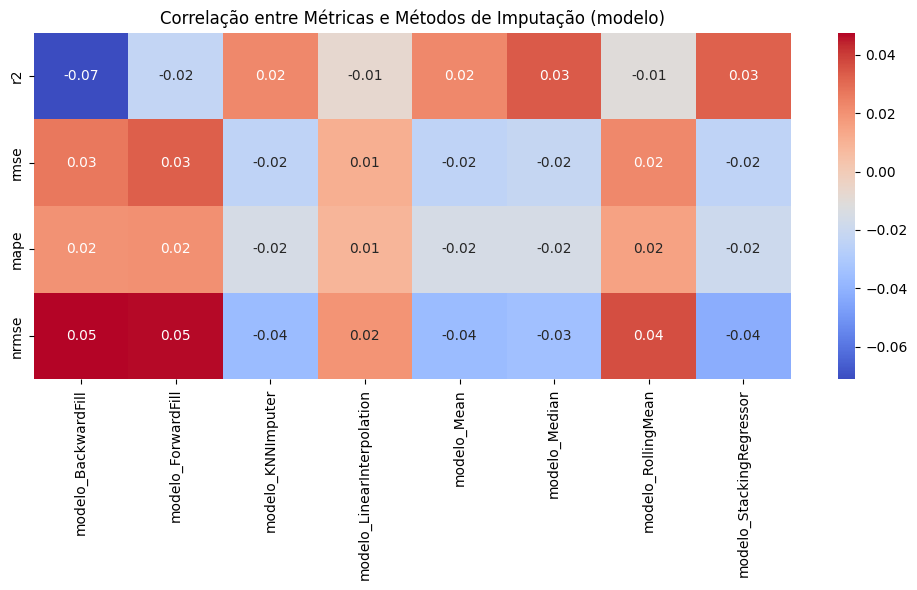

=== Melhoria do Stacking vs Baseline ===
📊 Melhoria do Stacking vs Baseline para R2:
Empty DataFrame
Columns: [mean, std, min, max]
Index: []


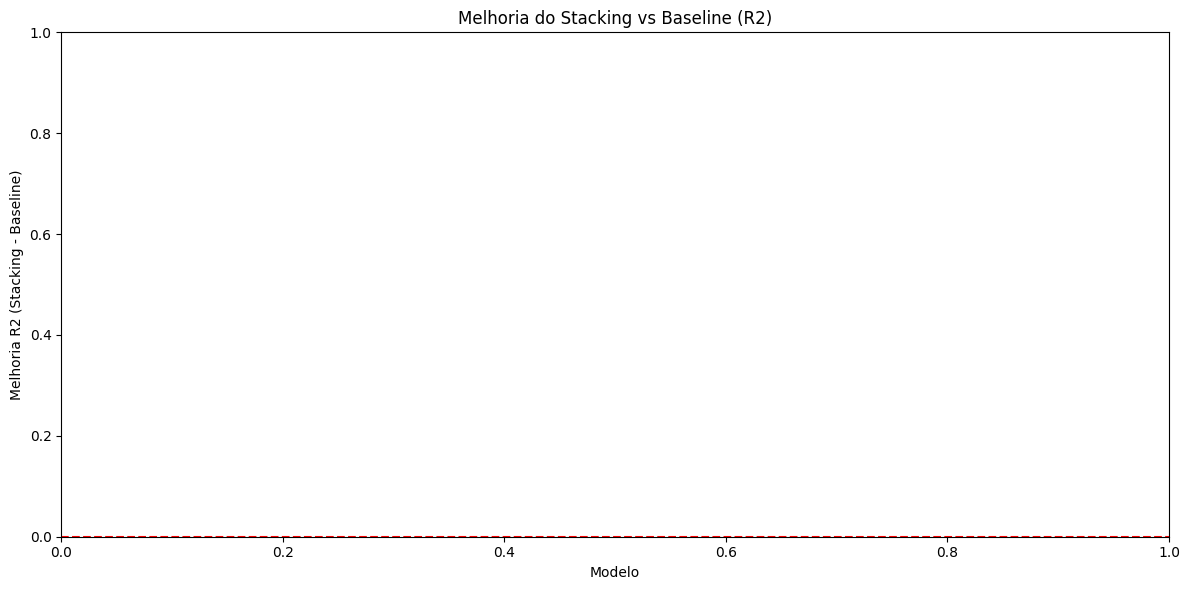

📊 Melhoria do Stacking vs Baseline para NRMSE:
Empty DataFrame
Columns: [mean, std, min, max]
Index: []


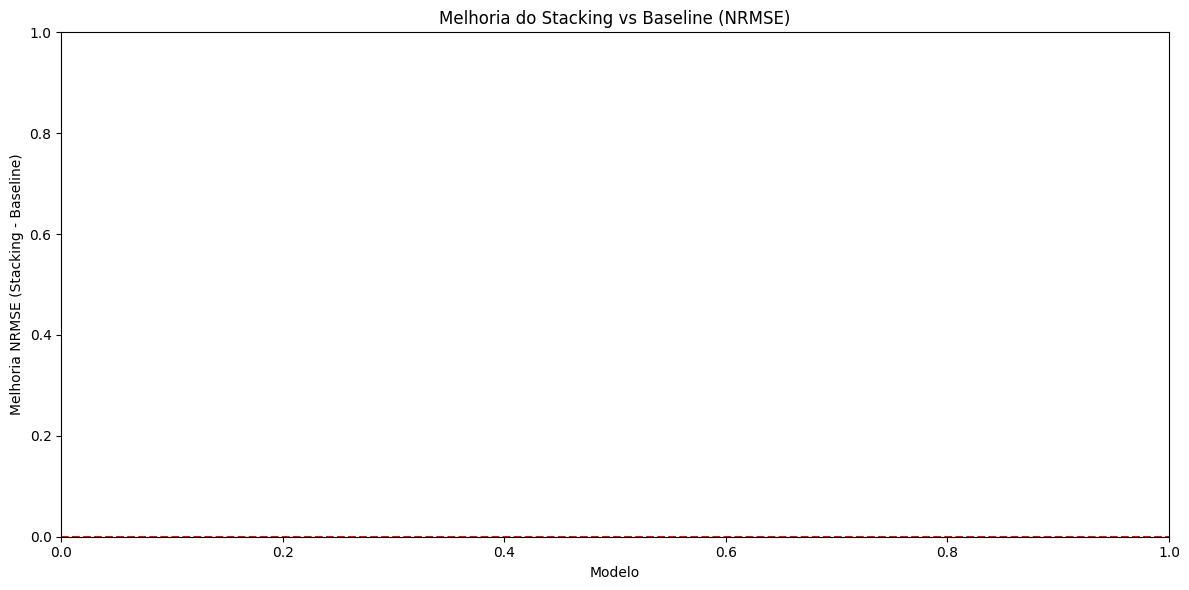

=== Comparação de Métricas por Método ===


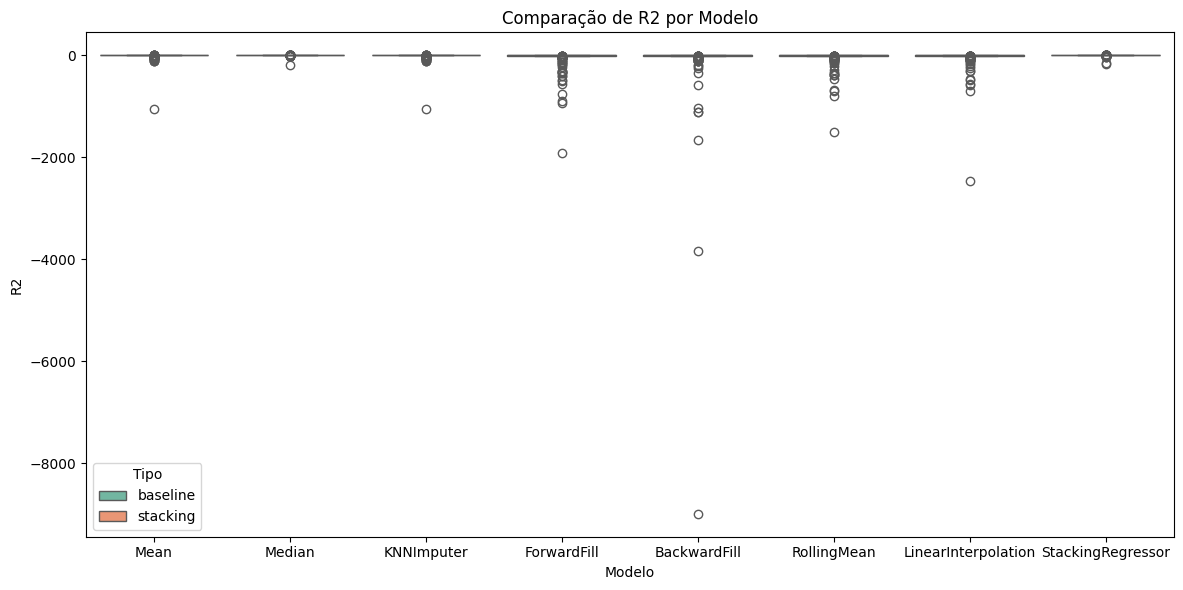

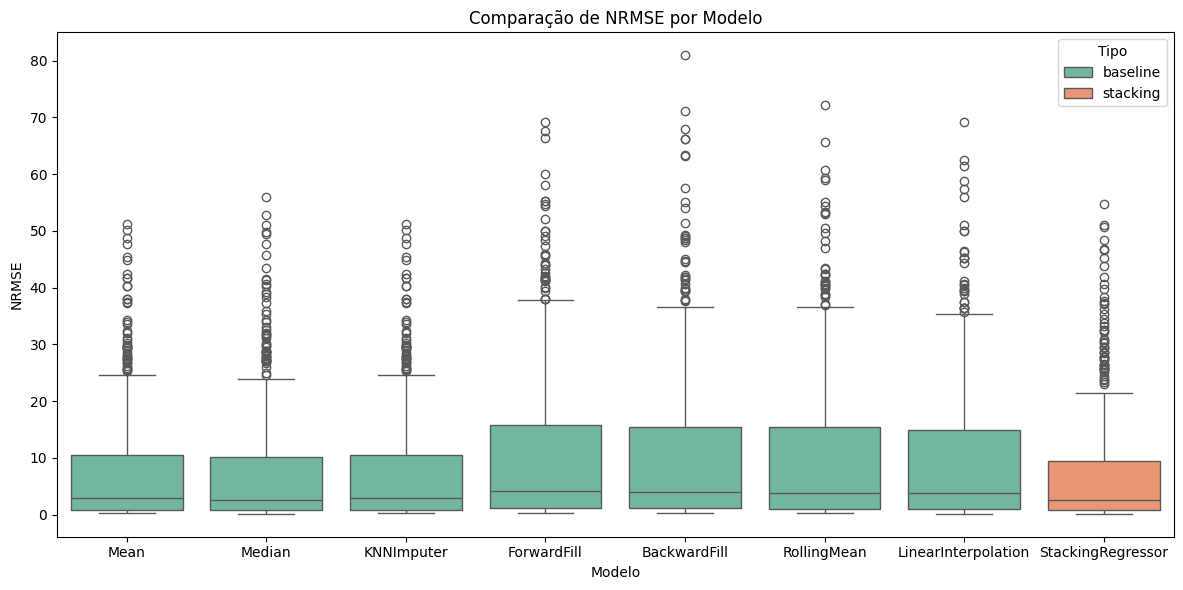

=== Exportando Resultados ===
💾 Resultados exportados para metrics_summary_analisado.csv


In [37]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


class ImputationAnalyzer:
    """
    Classe para análise de desempenho de imputação considerando variabilidade
    por percentual de dados imputados, sem remoções ou filtros.
    """

    def __init__(self, metrics_json_path: str):
        """
        Inicializa o analisador a partir do arquivo JSON filtrado.

        Args:
            metrics_json_path (str): Caminho para o arquivo JSON filtrado.
        """
        self.metrics_json_path = metrics_json_path
        self.metrics_data = self._load_json()
        self.metrics_df = self._convert_to_dataframe()
        print(f"✅ JSON carregado com {len(self.metrics_df)} registros.")

    def _load_json(self):
        """Carrega o arquivo JSON."""
        with open(self.metrics_json_path, 'r') as f:
            return json.load(f)

    def _convert_to_dataframe(self):
        """Converte o JSON hierárquico em um DataFrame plano incluindo stacking."""
        records = []

        for link, imputacoes in self.metrics_data.items():
            for perc_str, categorias in imputacoes.items():
                try:
                    perc = float(perc_str)
                except ValueError:
                    continue

                # Baseline
                for modelo_name, metricas in categorias.get('baseline', {}).items():
                    rec = {
                        "link": link,
                        "imputation_percentage": perc,
                        "tipo": "baseline",
                        "modelo": modelo_name
                    }
                    rec.update(metricas)
                    records.append(rec)

                # Stacking
                for stacking_type, stacking_models in categorias.get('stacking', {}).items():
                    for modelo_name, metricas in stacking_models.items():
                        rec = {
                            "link": link,
                            "imputation_percentage": perc,
                            "tipo": "stacking",
                            "modelo": modelo_name
                        }
                        rec.update(metricas)
                        records.append(rec)

        df = pd.DataFrame(records)
        print("📊 Colunas disponíveis:", df.columns.tolist())
        return df

    # =====================================================
    # MÉTODOS DE ANÁLISE
    # =====================================================

    def resumo_geral(self):
        """
        Exibe estatísticas descritivas das métricas separadas por modelo e tipo (baseline/stacking).
        """
        if self.metrics_df is None or self.metrics_df.empty:
            raise ValueError("Nenhum dado carregado para análise.")

        # Verifica as métricas existentes
        metricas_existentes = [m for m in ['r2', 'rmse', 'nrmse', 'mape'] if m in self.metrics_df.columns]

        # Estatísticas descritivas agrupadas por modelo e tipo
        resumo = (
            self.metrics_df
            .groupby(['modelo', 'tipo'])[metricas_existentes]
            .agg(['mean', 'std', 'min', 'max'])
            .round(3)
        )

        print("📊 Estatísticas descritivas por modelo e tipo:")
        return resumo

    def analisar_porcentagem_imputacao(self):
        """Analisa a variação das métricas conforme a porcentagem de imputação, separando baseline e stacking."""
        # Detecta quais métricas existem
        metricas_existentes = [m for m in ['r2', 'rmse', 'nrmse', 'mape', 'mae'] if m in self.metrics_df.columns]
        if not metricas_existentes:
            raise ValueError("Nenhuma métrica válida encontrada no DataFrame!")

        # Dicionário de agregação
        agg_dict = {m: 'mean' for m in metricas_existentes}

        # Inclui também 'tipo' para manter a distinção entre baseline e stacking
        grouped = (
            self.metrics_df.groupby(['imputation_percentage', 'tipo', 'modelo'])
            .agg(agg_dict)
            .reset_index()
        )

        print(f"📊 Análise por % de imputação concluída ({len(metricas_existentes)} métricas detectadas).")
        return grouped

    def plot_variabilidade_por_imputacao(self, metrica='r2'):
        """Plota o desempenho médio por percentual de imputação, separando baseline e stacking."""
        df_grouped = self.analisar_porcentagem_imputacao()

        # Verifica se a métrica existe
        if metrica not in df_grouped.columns:
            raise ValueError(f"Métrica '{metrica}' não encontrada. Colunas disponíveis: {df_grouped.columns.tolist()}")

        plt.figure(figsize=(10, 6))
        sns.lineplot(
            data=df_grouped,
            x='imputation_percentage',
            y=metrica,
            hue='modelo',
            style='tipo',  # ← separa baseline e stacking visualmente
            markers=True,
            dashes=False
        )

        plt.title(f'Variação de {metrica.upper()} por Percentual de Imputação\n(Baseline vs Stacking)')
        plt.xlabel('Percentual de Imputação (%)')
        plt.ylabel(metrica.upper())
        plt.legend(title='Modelo / Tipo', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

    def correlacao_metricas(self, metodo='modelo'):
        """
        Mostra um heatmap de correlação entre as métricas de desempenho
        e os métodos de imputação (baseline/stacking ou modelos específicos).
        
        Args:
            metodo (str): Coluna a usar como codificação de método, pode ser 'modelo' ou 'tipo'.
        """
        # Seleciona métricas existentes
        metricas = [m for m in ['r2', 'rmse', 'mape', 'nrmse', 'mae'] if m in self.metrics_df.columns]
        
        if not metricas:
            raise ValueError("Nenhuma métrica válida encontrada no DataFrame!")

        # Cria dummies para os métodos de imputação
        dummies = pd.get_dummies(self.metrics_df[metodo], prefix=metodo)
        
        # Concatena as métricas e os dummies
        df_corr_input = pd.concat([self.metrics_df[metricas], dummies], axis=1)
        
        # Calcula correlação
        df_corr = df_corr_input.corr()

        # Apenas correlação entre métricas e métodos
        corr_metodos_metricas = df_corr.loc[metricas, dummies.columns]

        plt.figure(figsize=(10, 6))
        sns.heatmap(corr_metodos_metricas, annot=True, cmap='coolwarm', fmt=".2f")
        plt.title(f'Correlação entre Métricas e Métodos de Imputação ({metodo})')
        plt.tight_layout()
        plt.show()


    def exportar_resultados(self, output_csv='metrics_summary_analisado.csv'):
        """Exporta o DataFrame consolidado para CSV."""
        self.metrics_df.to_csv(output_csv, index=False)
        print(f"💾 Resultados exportados para {output_csv}")

    def comparar_modelos(self, metrica='r2'):
        """
        Gera um boxplot comparando os modelos em uma métrica específica.
        Considera tanto baseline quanto stacking.
        """
        if self.metrics_df is None or self.metrics_df.empty:
            raise ValueError("Nenhum dado de métricas encontrado. Carregue o JSON primeiro.")

        if metrica not in self.metrics_df.columns:
            raise ValueError(f"Métrica '{metrica}' não encontrada. Colunas disponíveis: {self.metrics_df.columns.tolist()}")

        plt.figure(figsize=(12, 6))
        sns.boxplot(
            data=self.metrics_df,
            x='modelo',
            y=metrica,
            hue='tipo',  # ← separa baseline e stacking
            palette='Set2'
        )

        plt.title(f'Comparação de Modelos - {metrica.upper()} (Baseline vs Stacking)')
        plt.xlabel('Modelo')
        plt.ylabel(metrica.upper())
        plt.legend(title='Tipo')
        plt.tight_layout()
        plt.show()
    
    def comparar_metricas_por_metodo(self, metrica='r2', metodo='modelo'):
        """
        Compara uma métrica entre os métodos de imputação (modelo ou tipo) usando boxplot.
        
        Args:
            metrica (str): Métrica a ser comparada ('r2', 'rmse', 'nrmse', etc.)
            metodo (str): Coluna a usar como método ('modelo' ou 'tipo')
        """
        if metrica not in self.metrics_df.columns:
            raise ValueError(f"Métrica '{metrica}' não encontrada. Colunas disponíveis: {self.metrics_df.columns.tolist()}")

        plt.figure(figsize=(12, 6))
        sns.boxplot(
            data=self.metrics_df,
            x=metodo,
            y=metrica,
            hue='tipo' if metodo=='modelo' else None,
            palette='Set2'
        )
        plt.title(f'Comparação de {metrica.upper()} por {metodo.capitalize()}')
        plt.xlabel(metodo.capitalize())
        plt.ylabel(metrica.upper())
        if metodo=='modelo':
            plt.legend(title='Tipo')
        plt.tight_layout()
        plt.show()

    def melhoria_stacking_vs_baseline(self, metrica='r2'):
        """
        Calcula a melhoria do Stacking em relação ao Baseline para uma métrica.
        
        Retorna um DataFrame com a diferença por modelo e imputation_percentage.
        """
        if metrica not in self.metrics_df.columns:
            raise ValueError(f"Métrica '{metrica}' não encontrada. Colunas disponíveis: {self.metrics_df.columns.tolist()}")

        # Separa baseline e stacking
        baseline_df = self.metrics_df[self.metrics_df['tipo'] == 'baseline']
        stacking_df = self.metrics_df[self.metrics_df['tipo'] == 'stacking']

        # Faz merge para alinhar mesmo modelo e mesma porcentagem de imputação
        merged = pd.merge(
            stacking_df,
            baseline_df,
            on=['link', 'modelo', 'imputation_percentage'],
            suffixes=('_stacking', '_baseline')
        )

        # Calcula melhoria
        merged[f'melhoria_{metrica}'] = merged[f'{metrica}_stacking'] - merged[f'{metrica}_baseline']

        # Estatísticas gerais
        resumo = merged.groupby('modelo')[f'melhoria_{metrica}'].agg(['mean', 'std', 'min', 'max']).round(3)
        print(f"📊 Melhoria do Stacking vs Baseline para {metrica.upper()}:")
        print(resumo)

        # Plot da distribuição da melhoria
        plt.figure(figsize=(12, 6))
        sns.boxplot(data=merged, x='modelo', y=f'melhoria_{metrica}')
        plt.axhline(0, color='red', linestyle='--')
        plt.title(f'Melhoria do Stacking vs Baseline ({metrica.upper()})')
        plt.xlabel('Modelo')
        plt.ylabel(f'Melhoria {metrica.upper()} (Stacking - Baseline)')
        plt.tight_layout()
        plt.show()

        return merged



# =====================================================
# EXEMPLO DE USO
# =====================================================

if __name__ == "__main__":
    analyzer = ImputationAnalyzer("metrics_summary_filtrado_62.json")

    # 1️⃣ Estatísticas gerais
    print("=== Resumo Geral ===")
    print(analyzer.resumo_geral())

    # 2️⃣ Comparação geral entre modelos
    print("=== Comparação Geral de Modelos (Boxplot) ===")
    analyzer.comparar_modelos(metrica='nrmse')

    # 3️⃣ Análise de variabilidade por % de imputação
    print("=== Variabilidade por Percentual de Imputação ===")
    analyzer.plot_variabilidade_por_imputacao(metrica='r2')
    analyzer.plot_variabilidade_por_imputacao(metrica='nrmse')

    # 4️⃣ Correlação entre métricas e métodos de imputação
    print("=== Correlação Métricas x Métodos ===")
    analyzer.correlacao_metricas(metodo='tipo')
    analyzer.correlacao_metricas(metodo='modelo')

    # 5️⃣ Melhoria do Stacking em relação ao Baseline
    print("=== Melhoria do Stacking vs Baseline ===")
    merged_melhoria_r2 = analyzer.melhoria_stacking_vs_baseline(metrica='r2')
    merged_melhoria_nrmse = analyzer.melhoria_stacking_vs_baseline(metrica='nrmse')

    # 6️⃣ Comparação de métricas entre métodos
    print("=== Comparação de Métricas por Método ===")
    analyzer.comparar_metricas_por_metodo(metrica='r2', metodo='modelo')
    analyzer.comparar_metricas_por_metodo(metrica='nrmse', metodo='modelo')

    # 7️⃣ Exporta resultados consolidados
    print("=== Exportando Resultados ===")
    analyzer.exportar_resultados(output_csv='metrics_summary_analisado.csv')


### Avaliando link por link

📊 Colunas disponíveis: ['link', 'imputation_percentage', 'tipo', 'modelo', 'rmse', 'nrmse', 'r2', 'mape']
✅ JSON carregado com 3192 registros.
📊 Estatísticas descritivas por link, modelo e tipo:
                                       r2                        rmse         \
                                     mean    std    min   max    mean    std   
link  modelo              tipo                                                 
ac-ap BackwardFill        baseline -3.360  3.153  -8.73 -1.03  59.113  6.471   
      ForwardFill         baseline -2.016  1.499  -5.31 -0.83  53.346  7.520   
      KNNImputer          baseline -1.520  1.382  -4.09 -0.15  47.086  4.685   
      LinearInterpolation baseline -1.421  0.996  -3.50 -0.57  49.791  7.524   
      Mean                baseline -1.520  1.382  -4.09 -0.15  47.086  4.685   
...                                   ...    ...    ...   ...     ...    ...   
to-pb LinearInterpolation baseline -3.914  3.526 -11.02 -0.78  10.127  3.375   
     

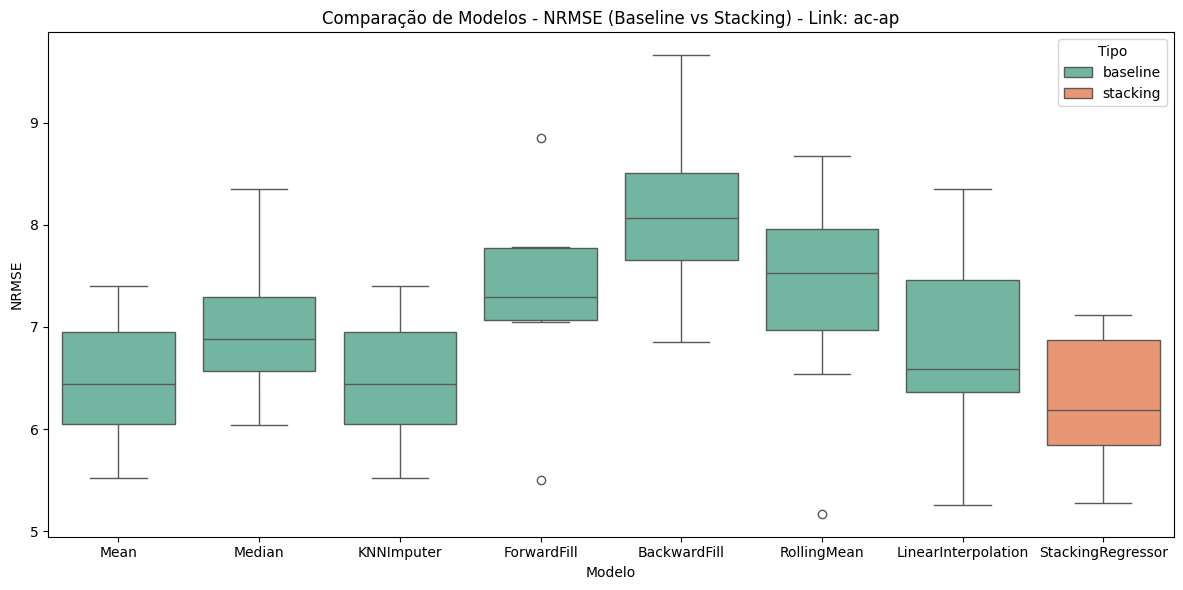

📊 Análise por % de imputação por link concluída (4 métricas detectadas).


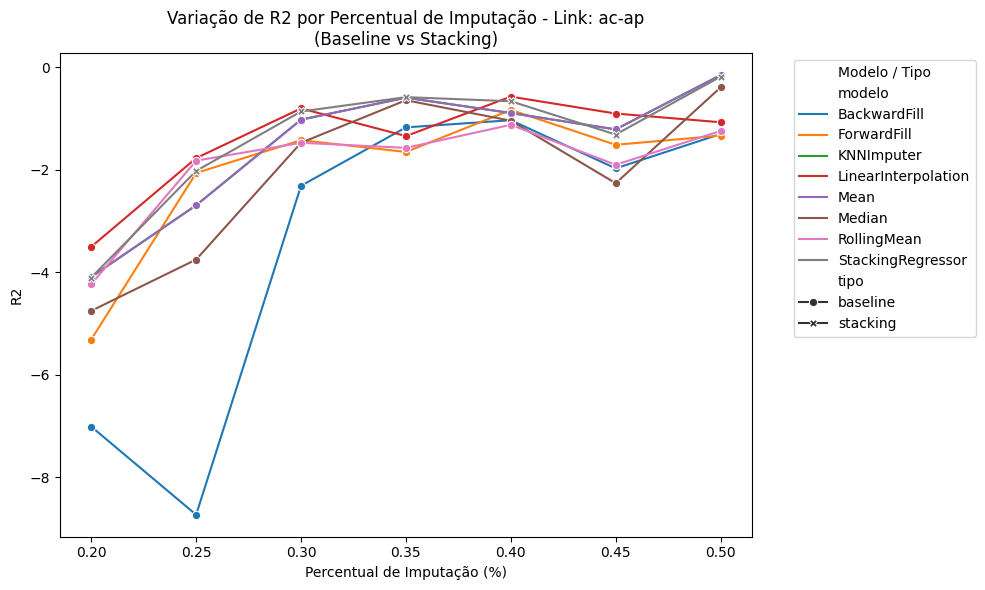

📊 Análise por % de imputação por link concluída (4 métricas detectadas).


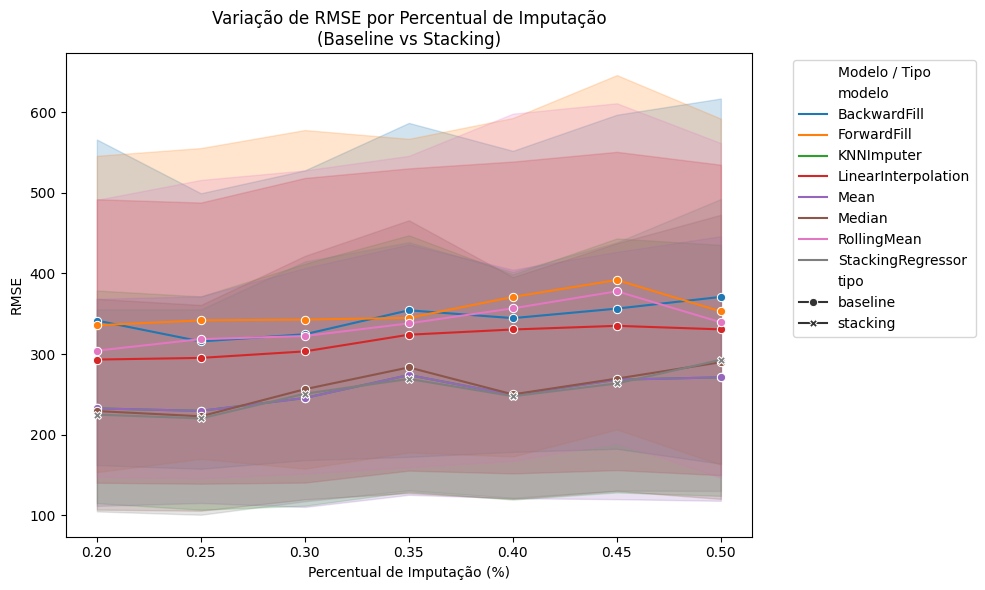

In [35]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


class ImputationAnalyzer:
    """
    Classe para análise de desempenho de imputação considerando variabilidade
    por percentual de dados imputados, sem remoções ou filtros.
    """

    def __init__(self, metrics_json_path: str):
        """
        Inicializa o analisador a partir do arquivo JSON filtrado.

        Args:
            metrics_json_path (str): Caminho para o arquivo JSON filtrado.
        """
        self.metrics_json_path = metrics_json_path
        self.metrics_data = self._load_json()
        self.metrics_df = self._convert_to_dataframe()
        print(f"✅ JSON carregado com {len(self.metrics_df)} registros.")

    def _load_json(self):
        """Carrega o arquivo JSON."""
        with open(self.metrics_json_path, 'r') as f:
            return json.load(f)

    def _convert_to_dataframe(self):
        """Converte o JSON hierárquico em um DataFrame plano incluindo stacking."""
        records = []

        for link, imputacoes in self.metrics_data.items():
            for perc_str, categorias in imputacoes.items():
                try:
                    perc = float(perc_str)
                except ValueError:
                    continue

                # Baseline
                for modelo_name, metricas in categorias.get('baseline', {}).items():
                    rec = {
                        "link": link,
                        "imputation_percentage": perc,
                        "tipo": "baseline",
                        "modelo": modelo_name
                    }
                    rec.update(metricas)
                    records.append(rec)

                # Stacking
                for stacking_type, stacking_models in categorias.get('stacking', {}).items():
                    for modelo_name, metricas in stacking_models.items():
                        rec = {
                            "link": link,
                            "imputation_percentage": perc,
                            "tipo": "stacking",
                            "modelo": modelo_name
                        }
                        rec.update(metricas)
                        records.append(rec)

        df = pd.DataFrame(records)
        print("📊 Colunas disponíveis:", df.columns.tolist())
        return df

    # =====================================================
    # MÉTODOS DE ANÁLISE
    # =====================================================

    def resumo_geral(self):
        """
        Exibe estatísticas descritivas das métricas separadas por modelo, tipo e link.
        """
        if self.metrics_df is None or self.metrics_df.empty:
            raise ValueError("Nenhum dado carregado para análise.")

        metricas_existentes = [m for m in ['r2', 'rmse', 'nrmse', 'mape'] if m in self.metrics_df.columns]

        resumo = (
            self.metrics_df
            .groupby(['link', 'modelo', 'tipo'])[metricas_existentes]
            .agg(['mean', 'std', 'min', 'max'])
            .round(3)
        )

        print("📊 Estatísticas descritivas por link, modelo e tipo:")
        return resumo

    def analisar_porcentagem_imputacao(self):
        """Analisa a variação das métricas conforme a porcentagem de imputação, separando baseline e stacking, por link."""
        metricas_existentes = [m for m in ['r2', 'rmse', 'nrmse', 'mape', 'mae'] if m in self.metrics_df.columns]
        if not metricas_existentes:
            raise ValueError("Nenhuma métrica válida encontrada no DataFrame!")

        agg_dict = {m: 'mean' for m in metricas_existentes}

        grouped = (
            self.metrics_df.groupby(['link', 'imputation_percentage', 'tipo', 'modelo'])
            .agg(agg_dict)
            .reset_index()
        )

        print(f"📊 Análise por % de imputação por link concluída ({len(metricas_existentes)} métricas detectadas).")
        return grouped

    def plot_variabilidade_por_imputacao(self, metrica='r2', link=None):
        """
        Plota o desempenho médio por percentual de imputação para um link específico
        ou para todos os links se link=None, separando baseline e stacking.
        """
        df_grouped = self.analisar_porcentagem_imputacao()

        if link is not None:
            df_grouped = df_grouped[df_grouped['link'] == link]

        if metrica not in df_grouped.columns:
            raise ValueError(f"Métrica '{metrica}' não encontrada. Colunas disponíveis: {df_grouped.columns.tolist()}")

        plt.figure(figsize=(10, 6))
        sns.lineplot(
            data=df_grouped,
            x='imputation_percentage',
            y=metrica,
            hue='modelo',
            style='tipo',
            markers=True,
            dashes=False
        )

        titulo = f'Variação de {metrica.upper()} por Percentual de Imputação'
        if link is not None:
            titulo += f' - Link: {link}'
        titulo += '\n(Baseline vs Stacking)'

        plt.title(titulo)
        plt.xlabel('Percentual de Imputação (%)')
        plt.ylabel(metrica.upper())
        plt.legend(title='Modelo / Tipo', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

    def comparar_modelos(self, metrica='r2', link=None):
        """
        Gera um boxplot comparando os modelos em uma métrica específica, opcionalmente por link.
        """
        df_plot = self.metrics_df
        if link is not None:
            df_plot = df_plot[df_plot['link'] == link]

        if df_plot.empty:
            raise ValueError(f"Nenhum dado disponível para o link '{link}'.")

        if metrica not in df_plot.columns:
            raise ValueError(f"Métrica '{metrica}' não encontrada. Colunas disponíveis: {df_plot.columns.tolist()}")

        plt.figure(figsize=(12, 6))
        sns.boxplot(
            data=df_plot,
            x='modelo',
            y=metrica,
            hue='tipo',
            palette='Set2'
        )

        titulo = f'Comparação de Modelos - {metrica.upper()} (Baseline vs Stacking)'
        if link is not None:
            titulo += f' - Link: {link}'
        plt.title(titulo)
        plt.xlabel('Modelo')
        plt.ylabel(metrica.upper())
        plt.legend(title='Tipo')
        plt.tight_layout()
        plt.show()


# =====================================================
# EXEMPLO DE USO
# =====================================================

if __name__ == "__main__":
    analyzer = ImputationAnalyzer("metrics_summary_filtrado_62.json")

    # Estatísticas gerais por link
    print(analyzer.resumo_geral())

    # Comparação de modelos por link específico
    analyzer.comparar_modelos(metrica='nrmse', link='ac-ap')

    # Análise de variabilidade por % de imputação para um link específico
    analyzer.plot_variabilidade_por_imputacao(metrica='r2', link='ac-ap')

    # Para todos os links (sem filtro)
    analyzer.plot_variabilidade_por_imputacao(metrica='rmse')



📊 Colunas disponíveis: ['link', 'imputation_percentage', 'tipo', 'modelo', 'rmse', 'nrmse', 'r2', 'mape']
✅ JSON carregado com 3192 registros.
📊 Estatísticas descritivas por link, modelo e tipo:
                                       r2                        rmse         \
                                     mean    std    min   max    mean    std   
link  modelo              tipo                                                 
ac-ap BackwardFill        baseline -3.360  3.153  -8.73 -1.03  59.113  6.471   
      ForwardFill         baseline -2.016  1.499  -5.31 -0.83  53.346  7.520   
      KNNImputer          baseline -1.520  1.382  -4.09 -0.15  47.086  4.685   
      LinearInterpolation baseline -1.421  0.996  -3.50 -0.57  49.791  7.524   
      Mean                baseline -1.520  1.382  -4.09 -0.15  47.086  4.685   
...                                   ...    ...    ...   ...     ...    ...   
to-pb LinearInterpolation baseline -3.914  3.526 -11.02 -0.78  10.127  3.375   
     

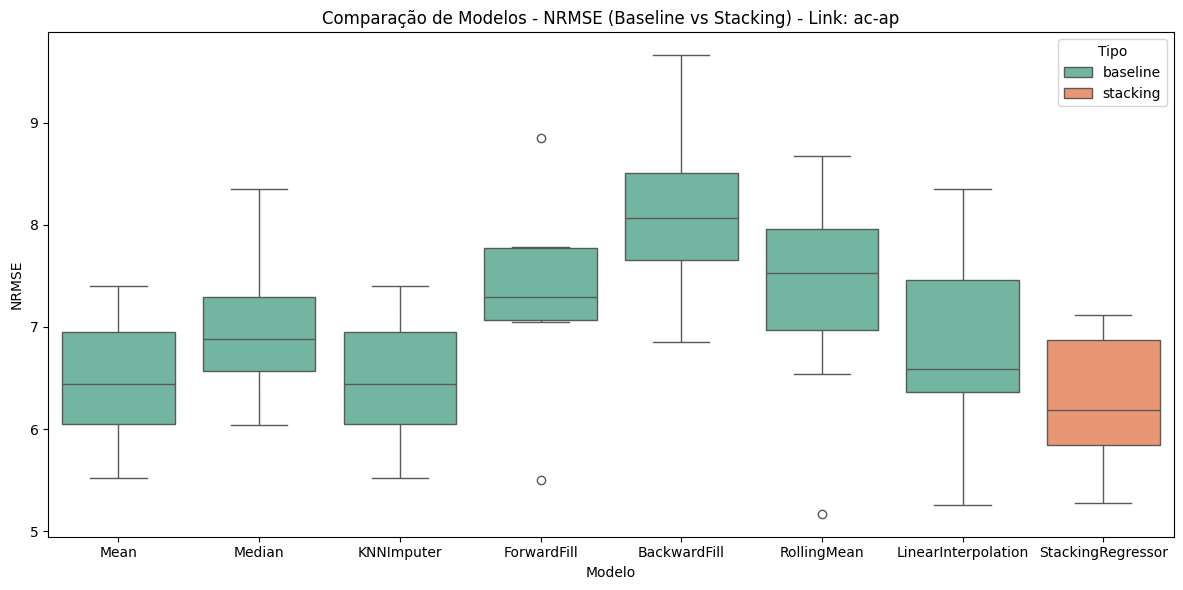

📊 Análise por % de imputação por link concluída (4 métricas detectadas).


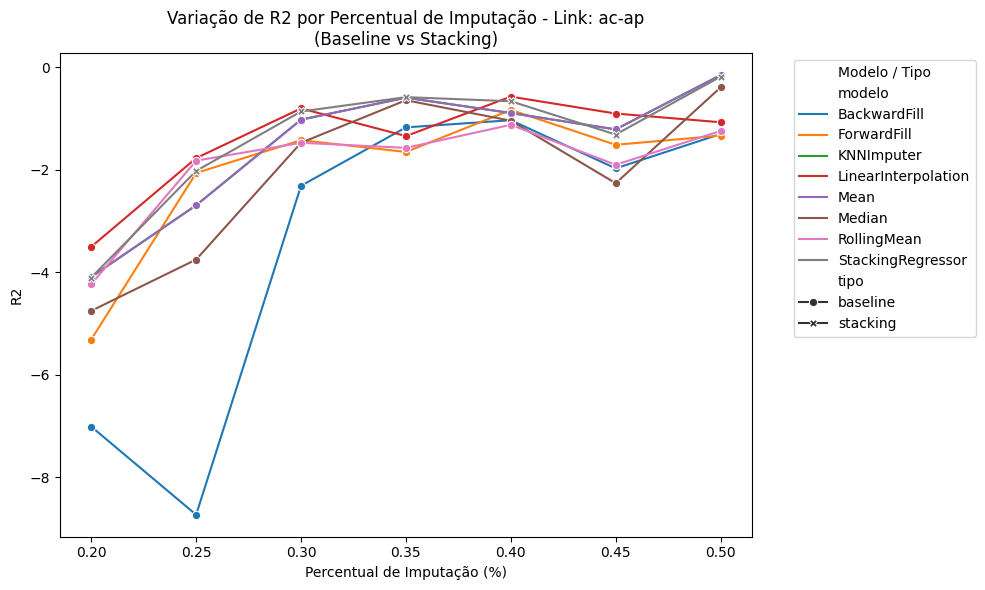

📊 Análise por % de imputação por link concluída (4 métricas detectadas).


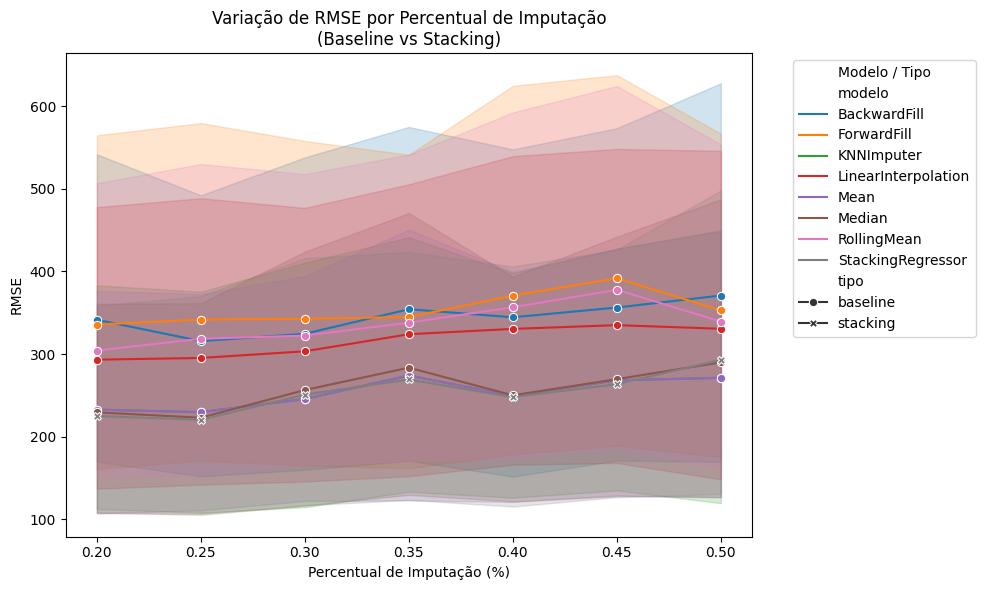

📊 Melhoria do Stacking vs Baseline para 'r2':
tipo     baseline   stacking    melhoria
link                                    
am-mt -257.557551  -0.915714  256.641837
rs-to -176.078776  -9.485714  166.593061
ms-pb -121.228571  -2.138571  119.090000
sp-pr -125.290000  -7.001667  118.288333
mt-sp  -83.600408  -2.127143   81.473265
pr-ce -107.499143 -34.000000   73.499143
pb-ro  -69.535306  -0.242857   69.292449
es-ba  -35.382653  -0.940000   34.442653
sc-rj  -34.580612  -3.495714   31.084898
to-am  -32.655918  -1.801429   30.854490
ce-se  -28.578571  -0.768571   27.810000
pb-pi  -28.092041  -4.381429   23.710612
mt-am  -15.742653  -0.122857   15.619796
sc-es  -12.513095  -1.400000   11.113095
sc-ba  -40.897143 -30.283333   10.613810
mt-go  -10.605918  -0.950000    9.655918
se-rj   -7.775714  -0.934000    6.841714
ba-es   -6.975918  -0.198571    6.777347
pa-mt   -6.874898  -0.494286    6.380612
pi-sc   -4.971224  -1.004286    3.966939
am-ro   -3.715306  -0.271429    3.443878
to-pb   -3.

C:\Users\LARCES_MALU\AppData\Local\Temp\ipykernel_35276\2033352543.py:202: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


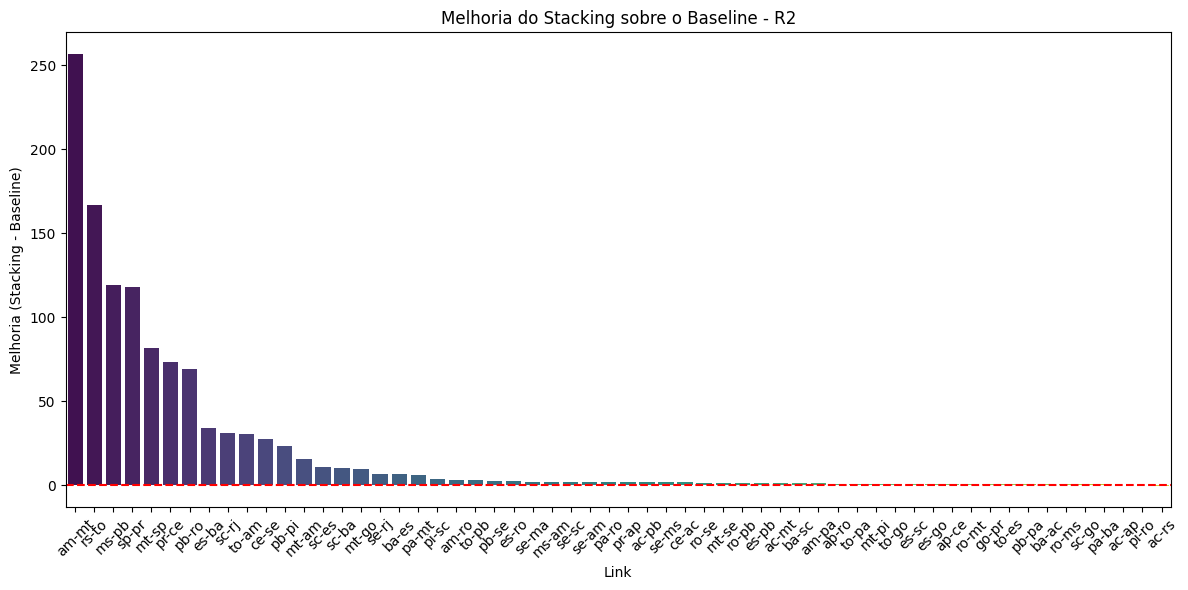

📊 Melhoria do Stacking vs Baseline para 'nrmse':
tipo    baseline   stacking  melhoria
link                                 
se-am  55.842449  47.517143 -8.325306
pb-pa  42.172245  34.224286 -7.947959
pb-ro  27.310816  20.118571 -7.192245
ap-ce  32.860204  27.894286 -4.965918
go-pr  39.144490  34.205714 -4.938776
sp-pr  22.012143  17.465000 -4.547143
se-sc  22.854082  18.701429 -4.152653
sc-ba  26.168095  22.173333 -3.994762
ba-sc  20.870000  17.378571 -3.491429
sc-go  33.044898  29.732857 -3.312041
sc-rj  35.169388  31.988571 -3.180816
pa-ba  16.783878  13.654286 -3.129592
ms-am  17.638980  14.624286 -3.014694
pb-se  16.605102  13.782857 -2.822245
pa-mt  19.450816  16.717143 -2.733673
rs-to   7.228571   4.711429 -2.517143
ce-ac   9.084898   7.037143 -2.047755
ac-pb   8.028571   6.007143 -2.021429
am-mt   5.592245   3.842857 -1.749388
mt-am   5.717143   4.200000 -1.517143
ba-es   4.856531   3.461429 -1.395102
ce-se   3.340000   2.038571 -1.301429
es-ba   4.771429   3.544286 -1.227143
b

C:\Users\LARCES_MALU\AppData\Local\Temp\ipykernel_35276\2033352543.py:202: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


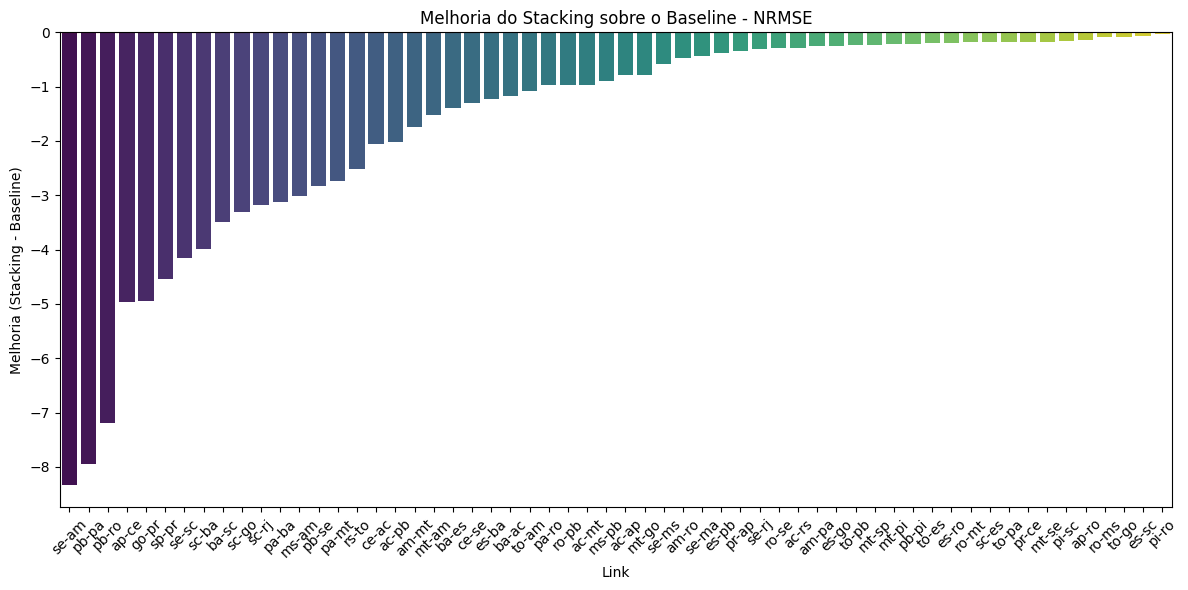

In [40]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


class ImputationAnalyzer:
    """
    Classe para análise de desempenho de imputação considerando variabilidade
    por percentual de dados imputados, sem remoções ou filtros.
    """

    def __init__(self, metrics_json_path: str):
        """
        Inicializa o analisador a partir do arquivo JSON filtrado.

        Args:
            metrics_json_path (str): Caminho para o arquivo JSON filtrado.
        """
        self.metrics_json_path = metrics_json_path
        self.metrics_data = self._load_json()
        self.metrics_df = self._convert_to_dataframe()
        print(f"✅ JSON carregado com {len(self.metrics_df)} registros.")

    def _load_json(self):
        """Carrega o arquivo JSON."""
        with open(self.metrics_json_path, 'r') as f:
            return json.load(f)

    def _convert_to_dataframe(self):
        """Converte o JSON hierárquico em um DataFrame plano incluindo stacking."""
        records = []

        for link, imputacoes in self.metrics_data.items():
            for perc_str, categorias in imputacoes.items():
                try:
                    perc = float(perc_str)
                except ValueError:
                    continue

                # Baseline
                for modelo_name, metricas in categorias.get('baseline', {}).items():
                    rec = {
                        "link": link,
                        "imputation_percentage": perc,
                        "tipo": "baseline",
                        "modelo": modelo_name
                    }
                    rec.update(metricas)
                    records.append(rec)

                # Stacking
                for stacking_type, stacking_models in categorias.get('stacking', {}).items():
                    for modelo_name, metricas in stacking_models.items():
                        rec = {
                            "link": link,
                            "imputation_percentage": perc,
                            "tipo": "stacking",
                            "modelo": modelo_name
                        }
                        rec.update(metricas)
                        records.append(rec)

        df = pd.DataFrame(records)
        print("📊 Colunas disponíveis:", df.columns.tolist())
        return df

    # =====================================================
    # MÉTODOS DE ANÁLISE
    # =====================================================

    def resumo_geral(self):
        """Exibe estatísticas descritivas das métricas separadas por modelo, tipo e link."""
        if self.metrics_df is None or self.metrics_df.empty:
            raise ValueError("Nenhum dado carregado para análise.")

        metricas_existentes = [m for m in ['r2', 'rmse', 'nrmse', 'mape'] if m in self.metrics_df.columns]

        resumo = (
            self.metrics_df
            .groupby(['link', 'modelo', 'tipo'])[metricas_existentes]
            .agg(['mean', 'std', 'min', 'max'])
            .round(3)
        )

        print("📊 Estatísticas descritivas por link, modelo e tipo:")
        return resumo

    def analisar_porcentagem_imputacao(self):
        """Analisa a variação das métricas conforme a porcentagem de imputação, separando baseline e stacking, por link."""
        metricas_existentes = [m for m in ['r2', 'rmse', 'nrmse', 'mape', 'mae'] if m in self.metrics_df.columns]
        if not metricas_existentes:
            raise ValueError("Nenhuma métrica válida encontrada no DataFrame!")

        agg_dict = {m: 'mean' for m in metricas_existentes}

        grouped = (
            self.metrics_df.groupby(['link', 'imputation_percentage', 'tipo', 'modelo'])
            .agg(agg_dict)
            .reset_index()
        )

        print(f"📊 Análise por % de imputação por link concluída ({len(metricas_existentes)} métricas detectadas).")
        return grouped

    def plot_variabilidade_por_imputacao(self, metrica='r2', link=None):
        """
        Plota o desempenho médio por percentual de imputação para um link específico
        ou para todos os links se link=None, separando baseline e stacking.
        """
        df_grouped = self.analisar_porcentagem_imputacao()

        if link is not None:
            df_grouped = df_grouped[df_grouped['link'] == link]

        if metrica not in df_grouped.columns:
            raise ValueError(f"Métrica '{metrica}' não encontrada. Colunas disponíveis: {df_grouped.columns.tolist()}")

        plt.figure(figsize=(10, 6))
        sns.lineplot(
            data=df_grouped,
            x='imputation_percentage',
            y=metrica,
            hue='modelo',
            style='tipo',
            markers=True,
            dashes=False
        )

        titulo = f'Variação de {metrica.upper()} por Percentual de Imputação'
        if link is not None:
            titulo += f' - Link: {link}'
        titulo += '\n(Baseline vs Stacking)'

        plt.title(titulo)
        plt.xlabel('Percentual de Imputação (%)')
        plt.ylabel(metrica.upper())
        plt.legend(title='Modelo / Tipo', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

    def comparar_modelos(self, metrica='r2', link=None):
        """Gera um boxplot comparando os modelos em uma métrica específica, opcionalmente por link."""
        df_plot = self.metrics_df
        if link is not None:
            df_plot = df_plot[df_plot['link'] == link]

        if df_plot.empty:
            raise ValueError(f"Nenhum dado disponível para o link '{link}'.")

        if metrica not in df_plot.columns:
            raise ValueError(f"Métrica '{metrica}' não encontrada. Colunas disponíveis: {df_plot.columns.tolist()}")

        plt.figure(figsize=(12, 6))
        sns.boxplot(
            data=df_plot,
            x='modelo',
            y=metrica,
            hue='tipo',
            palette='Set2'
        )

        titulo = f'Comparação de Modelos - {metrica.upper()} (Baseline vs Stacking)'
        if link is not None:
            titulo += f' - Link: {link}'
        plt.title(titulo)
        plt.xlabel('Modelo')
        plt.ylabel(metrica.upper())
        plt.legend(title='Tipo')
        plt.tight_layout()
        plt.show()

    def melhoria_stacking_vs_baseline(self, metrica='r2'):
        """
        Calcula a melhoria do Stacking em relação ao Baseline por link.
        Retorna um DataFrame com a diferença média da métrica.
        """
        metricas_existentes = [m for m in ['r2', 'rmse', 'nrmse', 'mape', 'mae'] if m in self.metrics_df.columns]
        if metrica not in metricas_existentes:
            raise ValueError(f"Métrica '{metrica}' não encontrada. Disponíveis: {metricas_existentes}")

        grouped = (
            self.metrics_df.groupby(['link', 'tipo'])[metrica]
            .mean()
            .unstack()
        )

        grouped['melhoria'] = grouped['stacking'] - grouped['baseline']
        grouped_sorted = grouped.sort_values(
            by='melhoria',
            ascending=(metrica in ['rmse', 'nrmse', 'mape', 'mae'])
        )

        print(f"📊 Melhoria do Stacking vs Baseline para '{metrica}':")
        print(grouped_sorted[['baseline', 'stacking', 'melhoria']])
        return grouped_sorted[['baseline', 'stacking', 'melhoria']]

    def plot_melhoria_stacking(self, metrica='r2'):
        """Plota um gráfico de barras mostrando a melhoria do Stacking sobre o Baseline por link."""
        df_melhoria = self.melhoria_stacking_vs_baseline(metrica)
        plt.figure(figsize=(12, 6))
        sns.barplot(
            data=df_melhoria.reset_index(),
            x='link',
            y='melhoria',
            palette='viridis'
        )
        plt.axhline(0, color='red', linestyle='--')
        plt.title(f'Melhoria do Stacking sobre o Baseline - {metrica.upper()}')
        plt.xlabel('Link')
        plt.ylabel('Melhoria (Stacking - Baseline)')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def exportar_resultados(self, output_csv='metrics_summary_analisado.csv'):
        """Exporta o DataFrame consolidado para CSV."""
        self.metrics_df.to_csv(output_csv, index=False)
        print(f"💾 Resultados exportados para {output_csv}")


# =====================================================
# EXEMPLO DE USO
# =====================================================

if __name__ == "__main__":
    analyzer = ImputationAnalyzer("metrics_summary_filtrado_62.json")

    # Estatísticas gerais por link
    print(analyzer.resumo_geral())

    # Comparação de modelos por link específico
    analyzer.comparar_modelos(metrica='nrmse', link='ac-ap')

    # Análise de variabilidade por % de imputação para um link específico
    analyzer.plot_variabilidade_por_imputacao(metrica='r2', link='ac-ap')

    # Para todos os links (sem filtro)
    analyzer.plot_variabilidade_por_imputacao(metrica='rmse')

    # Melhoria do Stacking vs Baseline
    melhoria_r2 = analyzer.melhoria_stacking_vs_baseline(metrica='r2')
    melhoria_nrmse = analyzer.melhoria_stacking_vs_baseline(metrica='nrmse')

    # Plot da melhoria
    analyzer.plot_melhoria_stacking(metrica='r2')
    analyzer.plot_melhoria_stacking(metrica='nrmse')


📊 Colunas disponíveis: ['link', 'imputation_percentage', 'tipo', 'modelo', 'rmse', 'nrmse', 'r2', 'mape']
✅ JSON carregado com 3192 registros.
📊 Estatísticas descritivas por link, modelo e tipo:
                                       r2                        rmse         \
                                     mean    std    min   max    mean    std   
link  modelo              tipo                                                 
ac-ap BackwardFill        baseline -3.360  3.153  -8.73 -1.03  59.113  6.471   
      ForwardFill         baseline -2.016  1.499  -5.31 -0.83  53.346  7.520   
      KNNImputer          baseline -1.520  1.382  -4.09 -0.15  47.086  4.685   
      LinearInterpolation baseline -1.421  0.996  -3.50 -0.57  49.791  7.524   
      Mean                baseline -1.520  1.382  -4.09 -0.15  47.086  4.685   
...                                   ...    ...    ...   ...     ...    ...   
to-pb LinearInterpolation baseline -3.914  3.526 -11.02 -0.78  10.127  3.375   
     

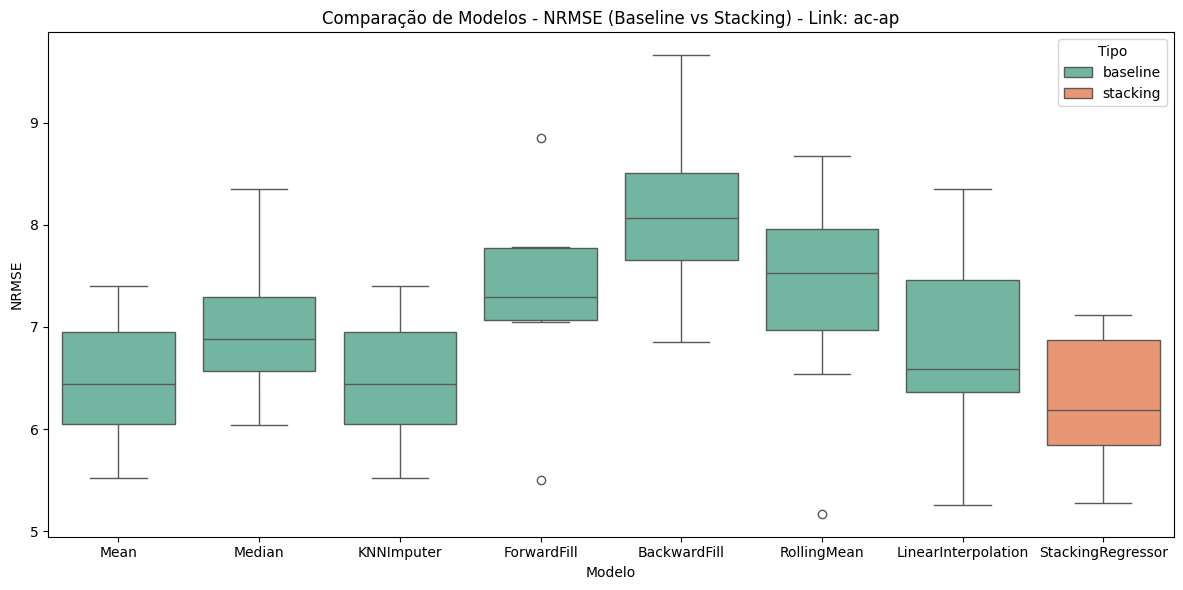

📊 Análise por % de imputação por link concluída (4 métricas detectadas).


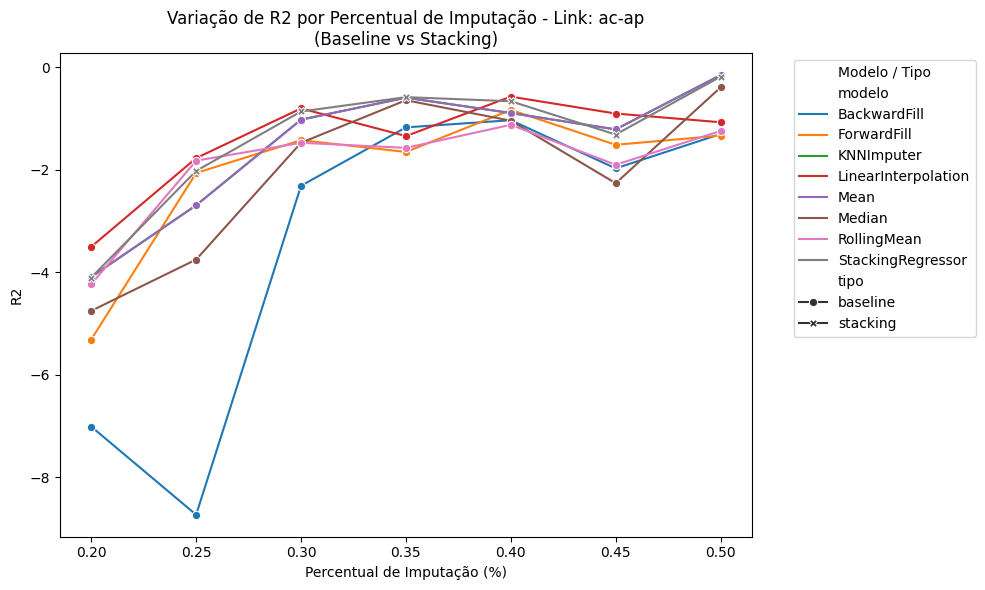

📊 Análise por % de imputação por link concluída (4 métricas detectadas).


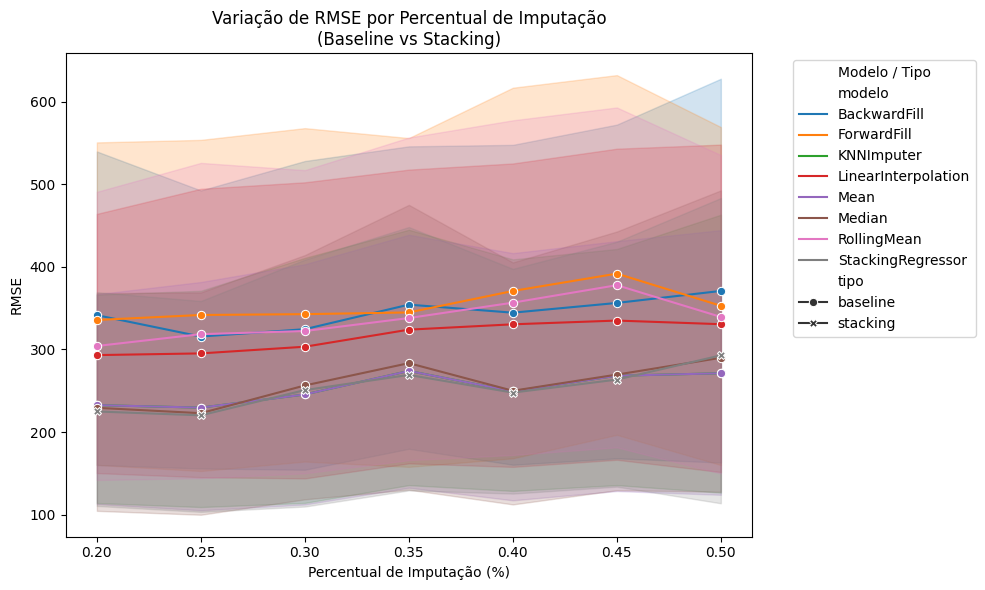

📊 Melhoria do Stacking vs Melhor Baseline para 'r2':
tipo   baseline  stacking  melhoria
link                               
am-mt  -8989.18     -2.55   8986.63
sp-pr  -3841.78    -36.01   3805.77
rs-to  -1910.70    -27.03   1883.67
ms-pb  -1654.08    -13.44   1640.64
mt-sp  -1115.09     -5.55   1109.54
pr-ce  -1060.66   -152.32    908.34
pb-pi   -681.05    -24.16    656.89
pb-ro   -586.13     -1.16    584.97
es-ba   -560.38     -3.72    556.66
to-am   -346.20     -7.30    338.90
sc-ba   -489.13   -175.99    313.14
sc-rj   -313.91     -9.39    304.52
ce-se   -240.85     -3.80    237.05
sc-es   -197.85     -3.91    193.94
mt-am   -130.34     -0.58    129.76
pa-mt    -72.92     -1.47     71.45
mt-go    -54.79     -3.24     51.55
ba-es    -48.17     -0.59     47.58
se-rj    -46.12     -2.26     43.86
se-am    -33.38     -0.84     32.54
am-ro    -32.13     -0.71     31.42
es-sc    -45.05    -15.24     29.81
to-pb    -29.66     -0.44     29.22
pb-se    -27.05     -0.64     26.41
es-ro    -2

C:\Users\LARCES_MALU\AppData\Local\Temp\ipykernel_35276\396171808.py:203: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


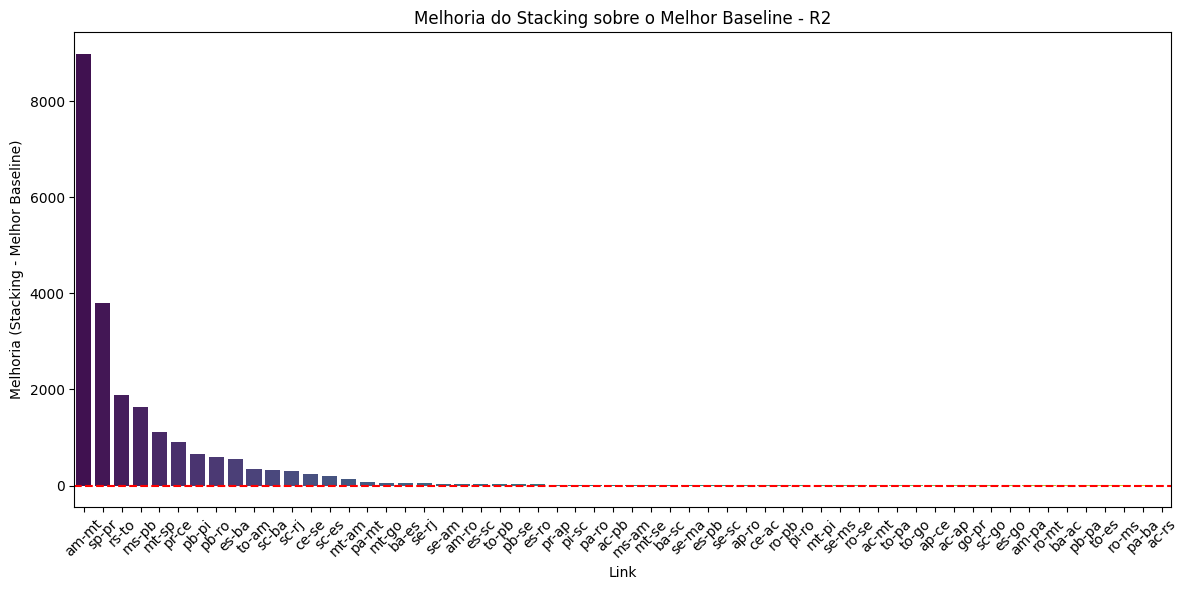

📊 Melhoria do Stacking vs Melhor Baseline para 'nrmse':
tipo   baseline  stacking  melhoria
link                               
ba-sc      9.48      7.30     -2.18
go-pr     19.43     17.62     -1.81
ms-am     11.09      9.57     -1.52
ap-ce     18.21     17.44     -0.77
ce-ac      4.09      3.41     -0.68
pa-ba     13.17     12.52     -0.65
sc-ba     15.39     14.80     -0.59
ac-pb      4.18      3.66     -0.52
pb-se      9.87      9.43     -0.44
se-sc     11.35     10.92     -0.43
mt-am      3.17      2.75     -0.42
pa-mt      9.01      8.60     -0.41
pa-ro      1.66      1.36     -0.30
se-rj      0.66      0.45     -0.21
ac-mt      3.99      3.81     -0.18
ba-es      0.91      0.74     -0.17
ba-ac      4.55      4.41     -0.14
es-pb      1.27      1.15     -0.12
mt-se      0.50      0.43     -0.07
pi-sc      0.33      0.26     -0.07
se-ma      0.86      0.79     -0.07
pb-ro      2.85      2.79     -0.06
sc-es      0.33      0.29     -0.04
to-pa      0.56      0.52     -0.04
to-es   

C:\Users\LARCES_MALU\AppData\Local\Temp\ipykernel_35276\396171808.py:203: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


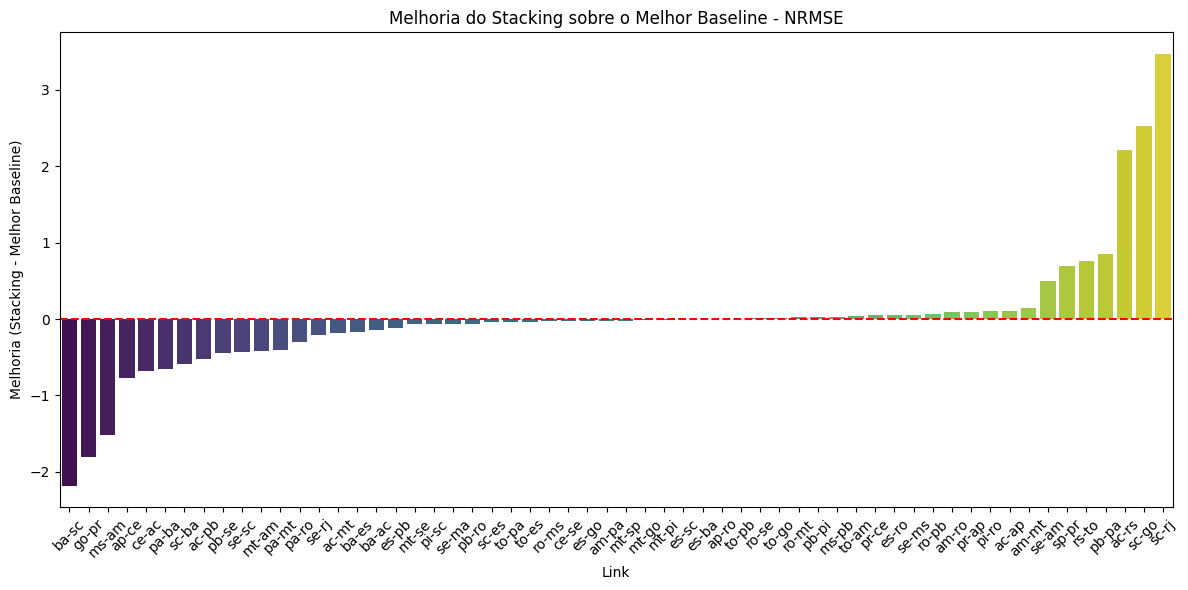

In [41]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


class ImputationAnalyzer:
    """
    Classe para análise de desempenho de imputação considerando variabilidade
    por percentual de dados imputados, sem remoções ou filtros.
    """

    def __init__(self, metrics_json_path: str):
        """
        Inicializa o analisador a partir do arquivo JSON filtrado.

        Args:
            metrics_json_path (str): Caminho para o arquivo JSON filtrado.
        """
        self.metrics_json_path = metrics_json_path
        self.metrics_data = self._load_json()
        self.metrics_df = self._convert_to_dataframe()
        print(f"✅ JSON carregado com {len(self.metrics_df)} registros.")

    def _load_json(self):
        """Carrega o arquivo JSON."""
        with open(self.metrics_json_path, 'r') as f:
            return json.load(f)

    def _convert_to_dataframe(self):
        """Converte o JSON hierárquico em um DataFrame plano incluindo stacking."""
        records = []

        for link, imputacoes in self.metrics_data.items():
            for perc_str, categorias in imputacoes.items():
                try:
                    perc = float(perc_str)
                except ValueError:
                    continue

                # Baseline
                for modelo_name, metricas in categorias.get('baseline', {}).items():
                    rec = {
                        "link": link,
                        "imputation_percentage": perc,
                        "tipo": "baseline",
                        "modelo": modelo_name
                    }
                    rec.update(metricas)
                    records.append(rec)

                # Stacking
                for stacking_type, stacking_models in categorias.get('stacking', {}).items():
                    for modelo_name, metricas in stacking_models.items():
                        rec = {
                            "link": link,
                            "imputation_percentage": perc,
                            "tipo": "stacking",
                            "modelo": modelo_name
                        }
                        rec.update(metricas)
                        records.append(rec)

        df = pd.DataFrame(records)
        print("📊 Colunas disponíveis:", df.columns.tolist())
        return df

    # =====================================================
    # MÉTODOS DE ANÁLISE
    # =====================================================

    def resumo_geral(self):
        """Exibe estatísticas descritivas das métricas separadas por modelo, tipo e link."""
        if self.metrics_df is None or self.metrics_df.empty:
            raise ValueError("Nenhum dado carregado para análise.")

        metricas_existentes = [m for m in ['r2', 'rmse', 'nrmse', 'mape'] if m in self.metrics_df.columns]

        resumo = (
            self.metrics_df
            .groupby(['link', 'modelo', 'tipo'])[metricas_existentes]
            .agg(['mean', 'std', 'min', 'max'])
            .round(3)
        )

        print("📊 Estatísticas descritivas por link, modelo e tipo:")
        return resumo

    def analisar_porcentagem_imputacao(self):
        """Analisa a variação das métricas conforme a porcentagem de imputação, separando baseline e stacking, por link."""
        metricas_existentes = [m for m in ['r2', 'rmse', 'nrmse', 'mape', 'mae'] if m in self.metrics_df.columns]
        if not metricas_existentes:
            raise ValueError("Nenhuma métrica válida encontrada no DataFrame!")

        agg_dict = {m: 'mean' for m in metricas_existentes}

        grouped = (
            self.metrics_df.groupby(['link', 'imputation_percentage', 'tipo', 'modelo'])
            .agg(agg_dict)
            .reset_index()
        )

        print(f"📊 Análise por % de imputação por link concluída ({len(metricas_existentes)} métricas detectadas).")
        return grouped

    def plot_variabilidade_por_imputacao(self, metrica='r2', link=None):
        """
        Plota o desempenho médio por percentual de imputação para um link específico
        ou para todos os links se link=None, separando baseline e stacking.
        """
        df_grouped = self.analisar_porcentagem_imputacao()

        if link is not None:
            df_grouped = df_grouped[df_grouped['link'] == link]

        if metrica not in df_grouped.columns:
            raise ValueError(f"Métrica '{metrica}' não encontrada. Colunas disponíveis: {df_grouped.columns.tolist()}")

        plt.figure(figsize=(10, 6))
        sns.lineplot(
            data=df_grouped,
            x='imputation_percentage',
            y=metrica,
            hue='modelo',
            style='tipo',
            markers=True,
            dashes=False
        )

        titulo = f'Variação de {metrica.upper()} por Percentual de Imputação'
        if link is not None:
            titulo += f' - Link: {link}'
        titulo += '\n(Baseline vs Stacking)'

        plt.title(titulo)
        plt.xlabel('Percentual de Imputação (%)')
        plt.ylabel(metrica.upper())
        plt.legend(title='Modelo / Tipo', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

    def comparar_modelos(self, metrica='r2', link=None):
        """Gera um boxplot comparando os modelos em uma métrica específica, opcionalmente por link."""
        df_plot = self.metrics_df
        if link is not None:
            df_plot = df_plot[df_plot['link'] == link]

        if df_plot.empty:
            raise ValueError(f"Nenhum dado disponível para o link '{link}'.")

        if metrica not in df_plot.columns:
            raise ValueError(f"Métrica '{metrica}' não encontrada. Colunas disponíveis: {df_plot.columns.tolist()}")

        plt.figure(figsize=(12, 6))
        sns.boxplot(
            data=df_plot,
            x='modelo',
            y=metrica,
            hue='tipo',
            palette='Set2'
        )

        titulo = f'Comparação de Modelos - {metrica.upper()} (Baseline vs Stacking)'
        if link is not None:
            titulo += f' - Link: {link}'
        plt.title(titulo)
        plt.xlabel('Modelo')
        plt.ylabel(metrica.upper())
        plt.legend(title='Tipo')
        plt.tight_layout()
        plt.show()

    def melhoria_stacking_vs_baseline(self, metrica='r2'):
        """
        Calcula a melhoria do Stacking em relação ao melhor Baseline por link.
        Retorna um DataFrame com a diferença da métrica.
        """
        metricas_existentes = [m for m in ['r2', 'rmse', 'nrmse', 'mape', 'mae'] if m in self.metrics_df.columns]
        if metrica not in metricas_existentes:
            raise ValueError(f"Métrica '{metrica}' não encontrada. Disponíveis: {metricas_existentes}")

        # Usa o melhor baseline (menor nrmse) e melhor stacking
        df_best = (
            self.metrics_df.groupby(['link', 'tipo'])[metrica]
            .min()  # <- pega o melhor valor
            .unstack()
        )

        df_best['melhoria'] = df_best['stacking'] - df_best['baseline']

        # Ordena pela maior melhoria (mais negativa = maior ganho)
        ascending = True if metrica in ['rmse', 'nrmse', 'mape', 'mae'] else False
        df_best_sorted = df_best.sort_values('melhoria', ascending=ascending)

        print(f"📊 Melhoria do Stacking vs Melhor Baseline para '{metrica}':")
        print(df_best_sorted[['baseline', 'stacking', 'melhoria']])
        return df_best_sorted[['baseline', 'stacking', 'melhoria']]

    def plot_melhoria_stacking(self, metrica='r2'):
        """Plota um gráfico de barras mostrando a melhoria do Stacking sobre o Melhor Baseline por link."""
        df_melhoria = self.melhoria_stacking_vs_baseline(metrica)
        plt.figure(figsize=(12, 6))
        sns.barplot(
            data=df_melhoria.reset_index(),
            x='link',
            y='melhoria',
            palette='viridis'
        )
        plt.axhline(0, color='red', linestyle='--')
        plt.title(f'Melhoria do Stacking sobre o Melhor Baseline - {metrica.upper()}')
        plt.xlabel('Link')
        plt.ylabel('Melhoria (Stacking - Melhor Baseline)')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def exportar_resultados(self, output_csv='metrics_summary_analisado.csv'):
        """Exporta o DataFrame consolidado para CSV."""
        self.metrics_df.to_csv(output_csv, index=False)
        print(f"💾 Resultados exportados para {output_csv}")


# =====================================================
# EXEMPLO DE USO
# =====================================================

if __name__ == "__main__":
    analyzer = ImputationAnalyzer("metrics_summary_filtrado_62.json")

    # Estatísticas gerais por link
    print(analyzer.resumo_geral())

    # Comparação de modelos por link específico
    analyzer.comparar_modelos(metrica='nrmse', link='ac-ap')

    # Análise de variabilidade por % de imputação para um link específico
    analyzer.plot_variabilidade_por_imputacao(metrica='r2', link='ac-ap')

    # Para todos os links (sem filtro)
    analyzer.plot_variabilidade_por_imputacao(metrica='rmse')

    # Melhoria do Stacking vs Melhor Baseline
    melhoria_r2 = analyzer.melhoria_stacking_vs_baseline(metrica='r2')
    melhoria_nrmse = analyzer.melhoria_stacking_vs_baseline(metrica='nrmse')

    # Plot da melhoria
    analyzer.plot_melhoria_stacking(metrica='r2')
    analyzer.plot_melhoria_stacking(metrica='nrmse')


📊 Colunas disponíveis: ['link', 'imputation_percentage', 'tipo', 'modelo', 'rmse', 'nrmse', 'r2', 'mape']
✅ JSON carregado com 3192 registros.
📊 Estatísticas descritivas por link, modelo e tipo:
                                       r2                        rmse         \
                                     mean    std    min   max    mean    std   
link  modelo              tipo                                                 
ac-ap BackwardFill        baseline -3.360  3.153  -8.73 -1.03  59.113  6.471   
      ForwardFill         baseline -2.016  1.499  -5.31 -0.83  53.346  7.520   
      KNNImputer          baseline -1.520  1.382  -4.09 -0.15  47.086  4.685   
      LinearInterpolation baseline -1.421  0.996  -3.50 -0.57  49.791  7.524   
      Mean                baseline -1.520  1.382  -4.09 -0.15  47.086  4.685   
...                                   ...    ...    ...   ...     ...    ...   
to-pb LinearInterpolation baseline -3.914  3.526 -11.02 -0.78  10.127  3.375   
     

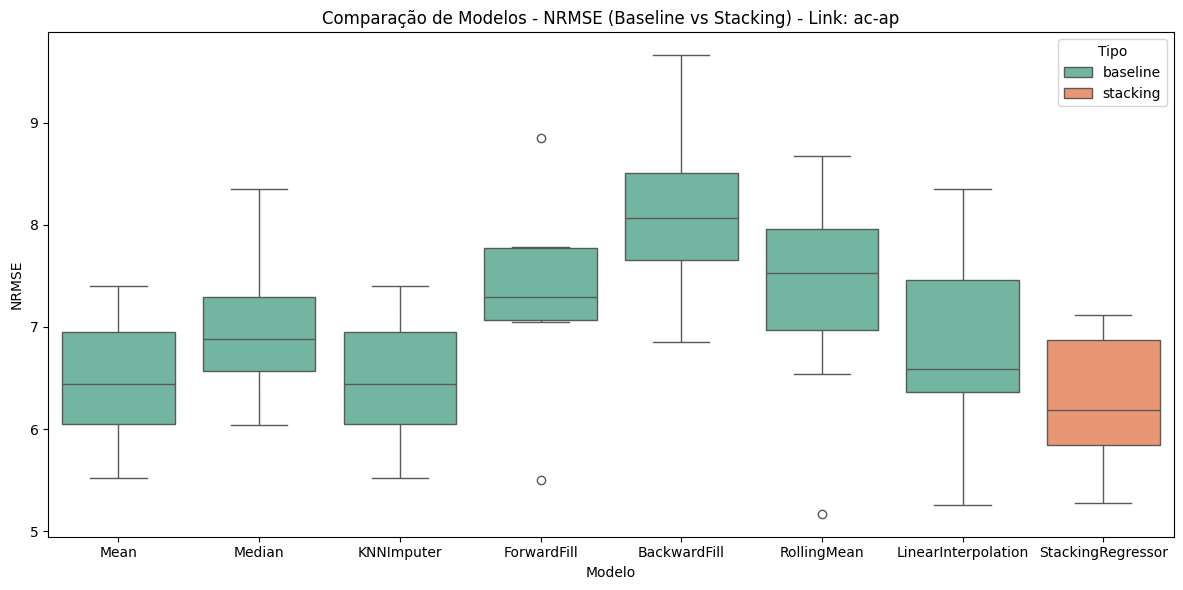

📊 Análise por % de imputação por link concluída (4 métricas detectadas).


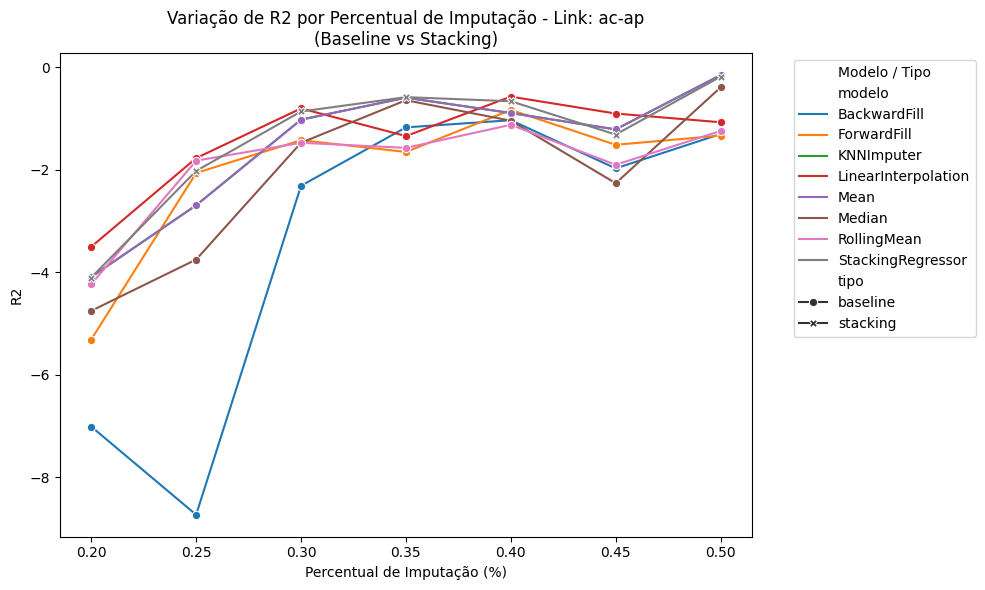

📊 Análise por % de imputação por link concluída (4 métricas detectadas).


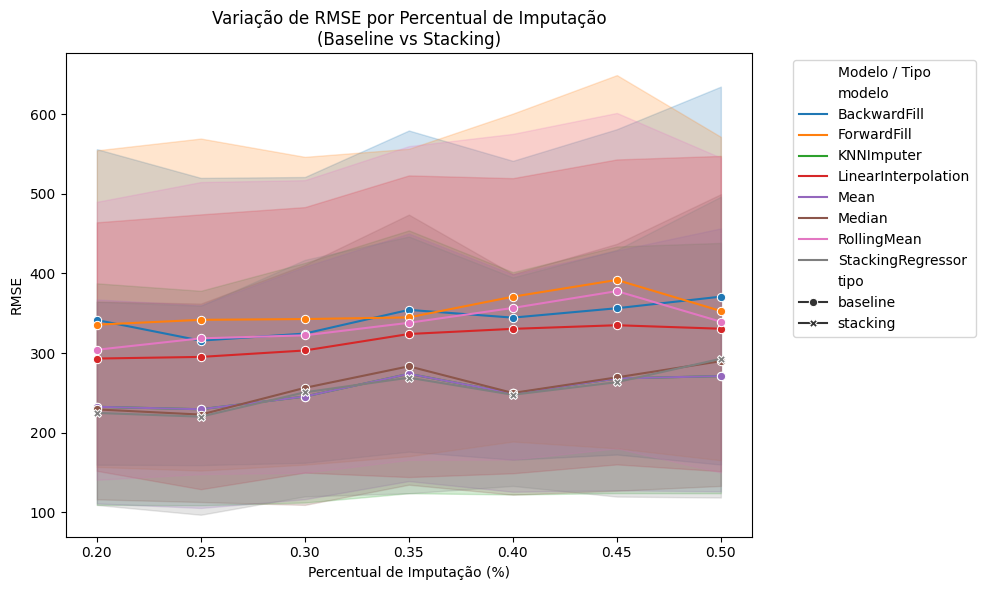

📊 Melhoria do Stacking vs Melhor Baseline para 'nrmse':
     link  baseline       baseline_model  stacking  melhoria
11  ba-sc      9.48                 Mean      7.30     -2.18
19  go-pr     19.43               Median     17.62     -1.81
20  ms-am     11.09               Median      9.57     -1.52
7   ap-ce     18.21               Median     17.44     -0.77
12  ce-ac      4.09               Median      3.41     -0.68
27  pa-ba     13.17               Median     12.52     -0.65
43  sc-ba     15.39                 Mean     14.80     -0.59
2   ac-pb      4.18                 Mean      3.66     -0.52
33  pb-se      9.87                 Mean      9.43     -0.44
51  se-sc     11.35               Median     10.92     -0.43
22  mt-am      3.17               Median      2.75     -0.42
28  pa-mt      9.01               Median      8.60     -0.41
29  pa-ro      1.66          ForwardFill      1.36     -0.30
50  se-rj      0.66                 Mean      0.45     -0.21
1   ac-mt      3.99          

C:\Users\LARCES_MALU\AppData\Local\Temp\ipykernel_35276\3687104362.py:166: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


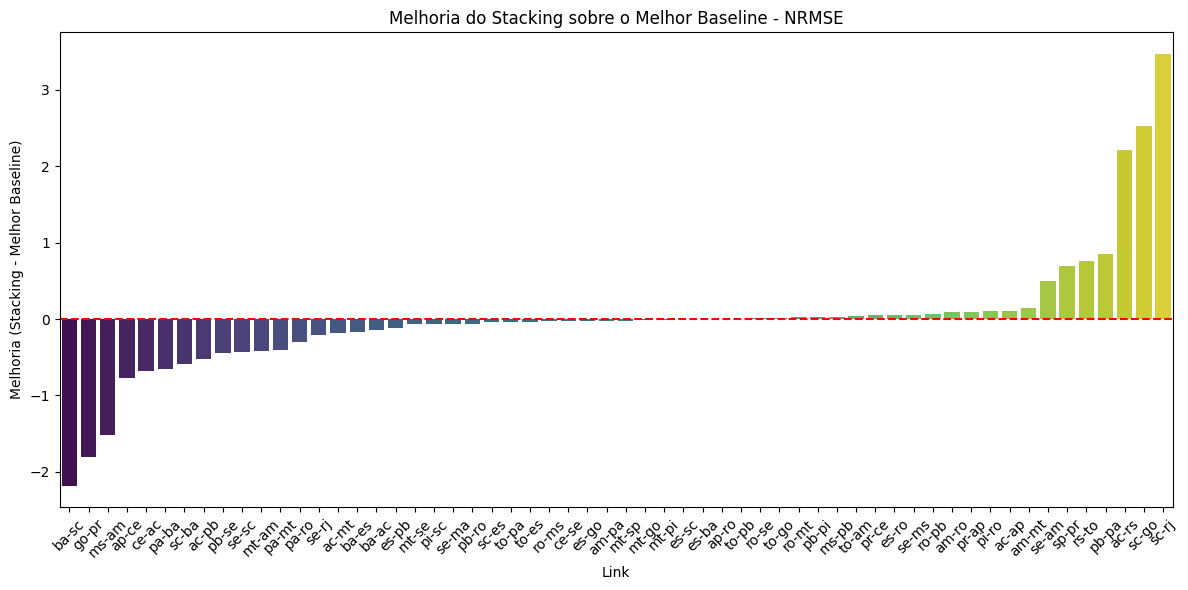

In [42]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


class ImputationAnalyzer:
    """
    Classe para análise de desempenho de imputação considerando variabilidade
    por percentual de dados imputados, sem remoções ou filtros.
    """

    def __init__(self, metrics_json_path: str):
        self.metrics_json_path = metrics_json_path
        self.metrics_data = self._load_json()
        self.metrics_df = self._convert_to_dataframe()
        print(f"✅ JSON carregado com {len(self.metrics_df)} registros.")

    def _load_json(self):
        with open(self.metrics_json_path, 'r') as f:
            return json.load(f)

    def _convert_to_dataframe(self):
        records = []

        for link, imputacoes in self.metrics_data.items():
            for perc_str, categorias in imputacoes.items():
                try:
                    perc = float(perc_str)
                except ValueError:
                    continue

                # Baseline
                for modelo_name, metricas in categorias.get('baseline', {}).items():
                    rec = {
                        "link": link,
                        "imputation_percentage": perc,
                        "tipo": "baseline",
                        "modelo": modelo_name
                    }
                    rec.update(metricas)
                    records.append(rec)

                # Stacking
                for stacking_type, stacking_models in categorias.get('stacking', {}).items():
                    for modelo_name, metricas in stacking_models.items():
                        rec = {
                            "link": link,
                            "imputation_percentage": perc,
                            "tipo": "stacking",
                            "modelo": modelo_name
                        }
                        rec.update(metricas)
                        records.append(rec)

        df = pd.DataFrame(records)
        print("📊 Colunas disponíveis:", df.columns.tolist())
        return df

    # =====================================================
    # MÉTODOS DE ANÁLISE
    # =====================================================

    def resumo_geral(self):
        metricas_existentes = [m for m in ['r2', 'rmse', 'nrmse', 'mape'] if m in self.metrics_df.columns]
        resumo = self.metrics_df.groupby(['link', 'modelo', 'tipo'])[metricas_existentes].agg(['mean','std','min','max']).round(3)
        print("📊 Estatísticas descritivas por link, modelo e tipo:")
        return resumo

    def analisar_porcentagem_imputacao(self):
        metricas_existentes = [m for m in ['r2', 'rmse', 'nrmse', 'mape', 'mae'] if m in self.metrics_df.columns]
        agg_dict = {m: 'mean' for m in metricas_existentes}
        grouped = self.metrics_df.groupby(['link', 'imputation_percentage', 'tipo', 'modelo']).agg(agg_dict).reset_index()
        print(f"📊 Análise por % de imputação por link concluída ({len(metricas_existentes)} métricas detectadas).")
        return grouped

    def plot_variabilidade_por_imputacao(self, metrica='r2', link=None):
        df_grouped = self.analisar_porcentagem_imputacao()
        if link is not None:
            df_grouped = df_grouped[df_grouped['link'] == link]
        plt.figure(figsize=(10, 6))
        sns.lineplot(
            data=df_grouped,
            x='imputation_percentage',
            y=metrica,
            hue='modelo',
            style='tipo',
            markers=True,
            dashes=False
        )
        titulo = f'Variação de {metrica.upper()} por Percentual de Imputação'
        if link is not None:
            titulo += f' - Link: {link}'
        titulo += '\n(Baseline vs Stacking)'
        plt.title(titulo)
        plt.xlabel('Percentual de Imputação (%)')
        plt.ylabel(metrica.upper())
        plt.legend(title='Modelo / Tipo', bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

    def comparar_modelos(self, metrica='r2', link=None):
        df_plot = self.metrics_df
        if link is not None:
            df_plot = df_plot[df_plot['link'] == link]
        plt.figure(figsize=(12, 6))
        sns.boxplot(
            data=df_plot,
            x='modelo',
            y=metrica,
            hue='tipo',
            palette='Set2'
        )
        titulo = f'Comparação de Modelos - {metrica.upper()} (Baseline vs Stacking)'
        if link is not None:
            titulo += f' - Link: {link}'
        plt.title(titulo)
        plt.xlabel('Modelo')
        plt.ylabel(metrica.upper())
        plt.legend(title='Tipo')
        plt.tight_layout()
        plt.show()

    def melhoria_stacking_vs_baseline(self, metrica='r2'):
        """
        Calcula a melhoria do Stacking em relação ao melhor Baseline por link,
        adicionando uma coluna com o nome do melhor baseline.
        """
        metricas_existentes = [m for m in ['r2','rmse','nrmse','mape','mae'] if m in self.metrics_df.columns]
        if metrica not in metricas_existentes:
            raise ValueError(f"Métrica '{metrica}' não encontrada. Disponíveis: {metricas_existentes}")

        resultados = []
        for link, df_link in self.metrics_df.groupby('link'):
            # Melhor baseline
            df_baseline = df_link[df_link['tipo']=='baseline']
            idx_best = df_baseline[metrica].idxmin() if metrica in ['rmse','nrmse','mape','mae'] else df_baseline[metrica].idxmax()
            best_baseline_val = df_baseline.loc[idx_best, metrica]
            best_baseline_model = df_baseline.loc[idx_best, 'modelo']

            # Melhor stacking
            df_stacking = df_link[df_link['tipo']=='stacking']
            idx_best_stack = df_stacking[metrica].idxmin() if metrica in ['rmse','nrmse','mape','mae'] else df_stacking[metrica].idxmax()
            best_stacking_val = df_stacking.loc[idx_best_stack, metrica]

            melhoria = best_stacking_val - best_baseline_val

            resultados.append({
                'link': link,
                'baseline': best_baseline_val,
                'baseline_model': best_baseline_model,
                'stacking': best_stacking_val,
                'melhoria': melhoria
            })

        df_result = pd.DataFrame(resultados)
        ascending = True if metrica in ['rmse','nrmse','mape','mae'] else False
        df_result = df_result.sort_values('melhoria', ascending=ascending)
        print(f"📊 Melhoria do Stacking vs Melhor Baseline para '{metrica}':")
        print(df_result)
        return df_result

    def plot_melhoria_stacking(self, metrica='r2'):
        df_melhoria = self.melhoria_stacking_vs_baseline(metrica)
        plt.figure(figsize=(12,6))
        sns.barplot(
            data=df_melhoria.reset_index(),
            x='link',
            y='melhoria',
            palette='viridis'
        )
        plt.axhline(0, color='red', linestyle='--')
        plt.title(f'Melhoria do Stacking sobre o Melhor Baseline - {metrica.upper()}')
        plt.xlabel('Link')
        plt.ylabel('Melhoria (Stacking - Melhor Baseline)')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

    def exportar_resultados(self, output_csv='metrics_summary_analisado.csv'):
        self.metrics_df.to_csv(output_csv, index=False)
        print(f"💾 Resultados exportados para {output_csv}")


# =====================================================
# EXEMPLO DE USO
# =====================================================
if __name__ == "__main__":
    analyzer = ImputationAnalyzer("metrics_summary_filtrado_62.json")
    print(analyzer.resumo_geral())
    analyzer.comparar_modelos(metrica='nrmse', link='ac-ap')
    analyzer.plot_variabilidade_por_imputacao(metrica='r2', link='ac-ap')
    analyzer.plot_variabilidade_por_imputacao(metrica='rmse')
    melhoria_nrmse = analyzer.melhoria_stacking_vs_baseline(metrica='nrmse')
    analyzer.plot_melhoria_stacking(metrica='nrmse')
